# Applying the trigger logic to all districts


In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [11]:
# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pathlib import Path
from matplotlib.patches import Rectangle
import calendar

import os
import re
import rasterio
import geopandas as gpd
import rasterstats as rs
from fuzzywuzzy import process
from unidecode import unidecode
from src.constants import *
from src.utils import *

# Display settings
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.1f}".format
sns.set(style="whitegrid")

In [12]:
# load admin boundaries
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)

In [13]:
district_df = pd.read_csv(
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "processed"
    / "moz"
    / "cholera"
    / "cholera_data_all_cleaned.csv"
)
# only keep those with week values
district_df = district_df[district_df["week"].notna()]

In [14]:
# using the 2025 file
gdf_adm2_pop = pd.read_csv(
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "worldpop"
    / "adm2_population_totals.csv"
)
gdf_adm2 = gdf_adm2.merge(
    gdf_adm2_pop,
    how="left",
    on="ADM2_PCODE",
    suffixes=("", "_pop"),
)

In [15]:
# it seems the admin bounds districts are not matching the cholera data ones
# trying some fuzzy matching to see if we can get a match


# add the population data to the gdf
pop_df = gdf_adm2[["ADM2_PT", "ADM1_PT", "sum_population"]].copy()
district_df.loc[:, "district_norm"] = district_df["district"].apply(normalize)
pop_df["ADM2_PT_norm"] = pop_df["ADM2_PT"].apply(normalize)
mapping = {}
for name in district_df["district_norm"]:
    result = process.extractOne(name, pop_df["ADM2_PT_norm"])
    if result:
        match, score = result[0], result[1]
    if score >= 80:  # threshold for matching
        match_row = pop_df[pop_df["ADM2_PT_norm"] == match].iloc[0]
        mapping[name] = match_row["ADM2_PT"]
district_df["matched_name"] = district_df["district_norm"].map(mapping)
district_df

province district  year  week  cases district_norm  \
0      Cabo Delgado  Ancuabe  2017   1.0  104.0       ancuabe   
1      Cabo Delgado  Ancuabe  2017   2.0  103.0       ancuabe   
2      Cabo Delgado  Ancuabe  2017   3.0   81.0       ancuabe   
3      Cabo Delgado  Ancuabe  2017   4.0   94.0       ancuabe   
4      Cabo Delgado  Ancuabe  2017   5.0   84.0       ancuabe   
...             ...      ...   ...   ...    ...           ...   
62962      Zambezia   Quelim  2024  48.0  371.0        quelim   
62963      Zambezia   Quelim  2024  49.0  311.0        quelim   
62964      Zambezia   Quelim  2024  50.0  373.0        quelim   
62965      Zambezia   Quelim  2024  51.0  317.0        quelim   
62966      Zambezia   Quelim  2024  52.0  386.0        quelim   

              matched_name  
0                  Ancuabe  
1                  Ancuabe  
2                  Ancuabe  
3                  Ancuabe  
4                  Ancuabe  
...                    ...  
62962  Cidade De Quelimane  
62963  Cidade De Quelimane  
62964  Cidade De Quelimane  
62965  Cidade De Quelimane  
62966  Cidade De Quelimane  

[62967 rows x 7 columns]

In [16]:
district_df["date"] = pd.to_datetime(
    district_df["year"].astype(str)
    + district_df["week"].astype(int).astype(str).str.zfill(2)
    + "1",
    format="%G%V%u",
)

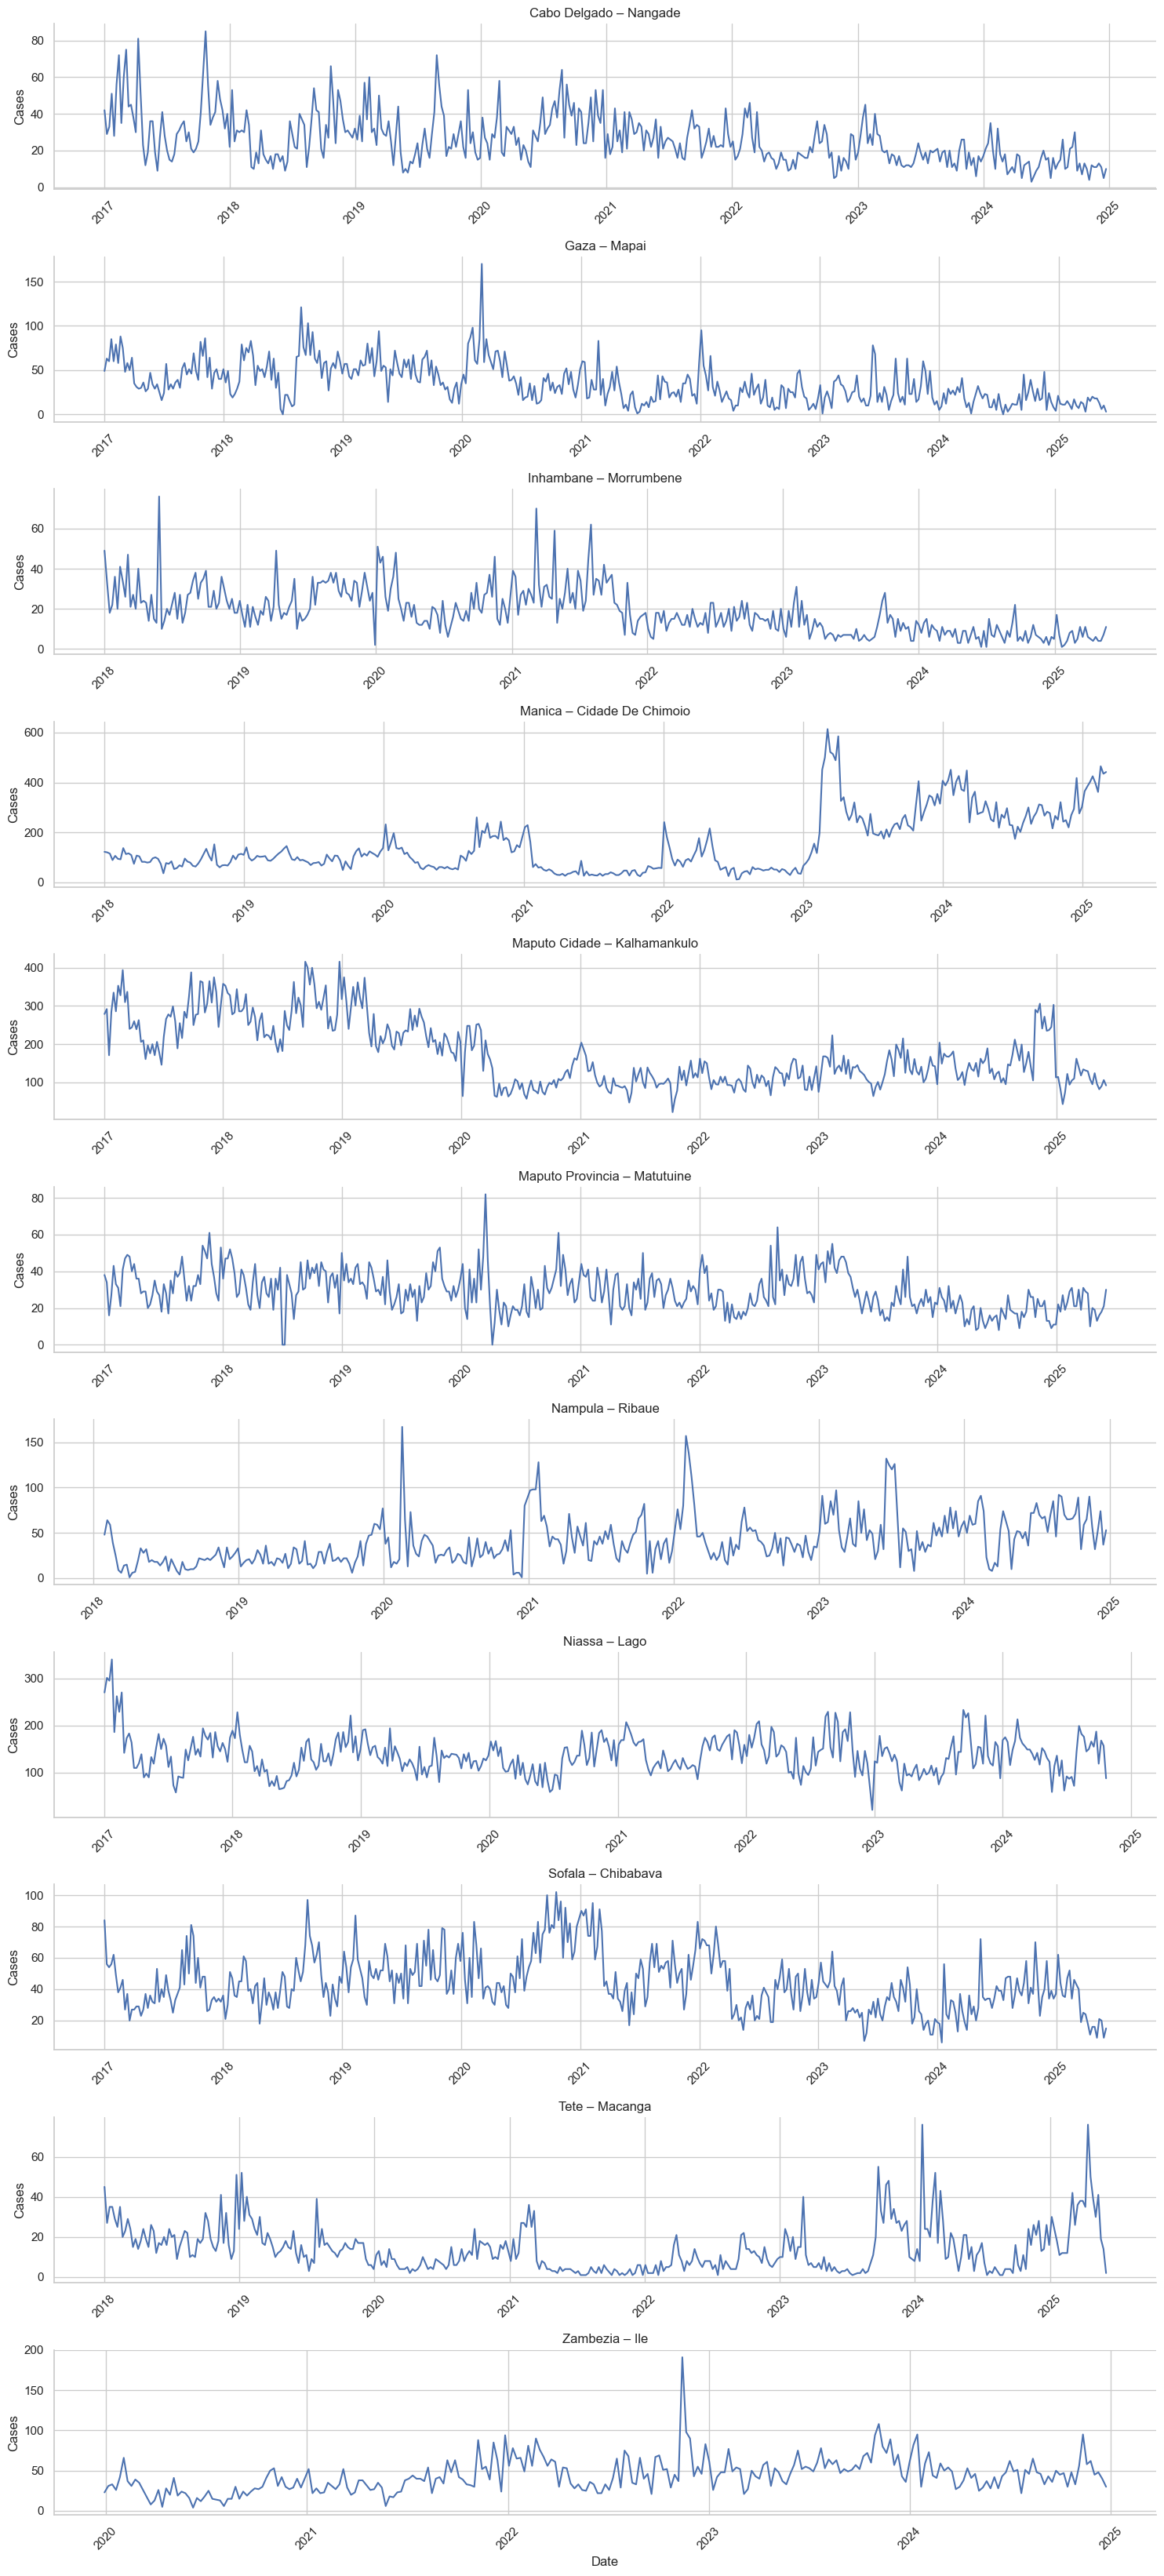

In [61]:
# Plot a random sample of one district per province
# to avoid too many plots, we will sample one district per province
selected_districts = (
    district_df.groupby("province")["district"]
    .apply(lambda x: x.sample(n=1, random_state=42).iloc[0])
    .tolist()
)
filtered_df = district_df[district_df["district"].isin(selected_districts)]
district_labels = filtered_df.groupby("province")["district"].first().to_dict()
g = sns.FacetGrid(
    filtered_df,
    row="province",
    sharex=False,
    sharey=False,
    height=3,
    aspect=5,
)
g.map_dataframe(sns.lineplot, x="date", y="cases")

for ax in g.axes.flat:
    province = ax.get_title().replace("province = ", "")
    district = district_labels.get(province, "")
    ax.set_title(f"{province} – {district}")

g.set_axis_labels("Date", "Cases")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

In [ ]:
# Normalise the cholera data by population
district_pop_df = district_df.merge(
    pop_df, left_on="matched_name", right_on="ADM2_PT", how="left"
)

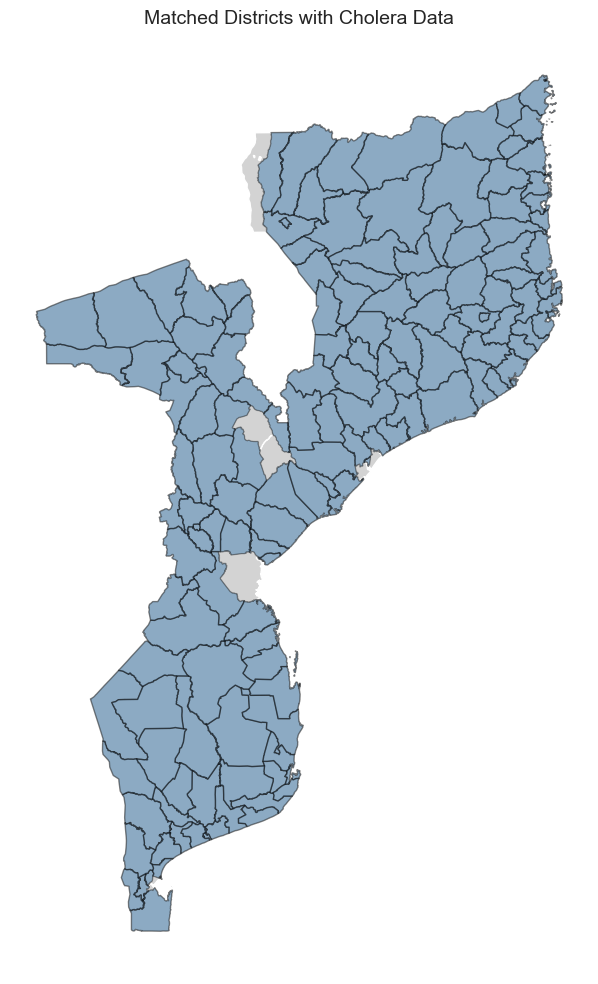

In [20]:
base = gdf_adm2.plot(color="lightgrey", edgecolor="white", figsize=(10, 10))

matched_districts = district_pop_df["ADM2_PT"].unique()
gdf_matched = gdf_adm2[gdf_adm2["ADM2_PT"].isin(matched_districts)]

gdf_matched.plot(ax=base, color="steelblue", edgecolor="black", alpha=0.5)

plt.title("Matched Districts with Cholera Data", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
# not all districts are in the cholera data

In [22]:
# check if merging is done well
# it should be empty if all the names are matched
district_pop_df[district_pop_df["ADM2_PT"].isna()][
    [
        "province",
        "district",
        "matched_name",
    ]
].drop_duplicates()

province      district matched_name
24080  Maputo Cidade  Kalhamankulo          NaN
24519  Maputo Cidade    Kamaxakene          NaN
24949  Maputo Cidade      Kampfumo          NaN
25387  Maputo Cidade   Kamubukwana          NaN
25816  Maputo Cidade       Kanyaka          NaN
26255  Maputo Cidade       Katembe          NaN
26684  Maputo Cidade       Mcidade          NaN
50168         Sofala        Sofala          NaN

In [28]:
# No district called Sofala

In [33]:
gdf_adm2[gdf_adm2["ADM1_PT"].isin(["Maputo City"])]

Shape_Leng  Shape_Area           ADM2_PT ADM2_PCODE ADM2_REF ADM2ALT1PT  \
30         1.8         0.0  Cidade De Maputo     MZ0601     None       None   

   ADM2ALT2PT      ADM1_PT ADM1_PCODE     ADM0_EN     ADM0_PT ADM0_PCODE  \
30       None  Maputo City       MZ06  Mozambique  Moçambique         MZ   

         date    validOn     validTo  \
30 2019-04-02 2019-06-07  0000/00/00   

                                             geometry  ADM1_PT_pop  \
30  MULTIPOLYGON (((32.99494 -25.97092, 32.99488 -...  Maputo City   

         ADM2_PT_pop  sum_population  
30  Cidade De Maputo     1,018,559.4

In [40]:
# now, normalise the cholera data by population
district_pop_df["cases_per_100k"] = (
    district_pop_df["cases"] / district_pop_df["sum_population"]
) * 100000
district_pop_df["cases_per_100k"].describe()

count   56,424.0
mean        40.6
std         48.0
min          0.0
25%         10.5
50%         25.8
75%         53.8
max        892.1
Name: cases_per_100k, dtype: float64

In [35]:
# check the distribution of the cases per 100k
# look at 99th percentile to set a trigger for each province OR 4x weekly increase in cases
# Calculate percentiles per province
percentiles = (
    district_pop_df[district_pop_df["cases_per_100k"] > 0]
    .groupby("province")["cases_per_100k"]
    .quantile([0.99])
    .unstack()
)

# Merge percentiles back into the main df
district_df_with_percentiles = district_pop_df.merge(
    percentiles.rename(columns={0.99: "p99"}),
    left_on="province",
    right_index=True,
    how="left",
)
district_df_with_percentiles["weekly_pct_increase"] = (
    district_df_with_percentiles
    # group by district and calculate percentage change
    .groupby("district")["cases_per_100k"].pct_change(fill_method=None)
    * 100
)

In [65]:
# Check if cases cross the thresholds
district_df_with_percentiles["above_99th"] = (
    district_df_with_percentiles["cases_per_100k"]
    > district_df_with_percentiles["p99"]
)
district_df_with_percentiles["above_4x"] = (
    district_df_with_percentiles["weekly_pct_increase"] >= 400
)
district_df_with_percentiles["threshold_crossed"] = (
    district_df_with_percentiles["above_99th"]
    | district_df_with_percentiles["above_4x"]
)
district_df_with_percentiles = district_df_with_percentiles.sort_values(
    ["district", "year", "week"]
)
# Create the new column: True only if this week and the previous two weeks are above the 99th percentile
district_df_with_percentiles["three_consec_crossing"] = (
    district_df_with_percentiles["threshold_crossed"]
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(1)
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(2)
    & (district_df_with_percentiles["cases"] >= 100)
)
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["province", "district"]].drop_duplicates()

province            district
45801            Sofala               Beira
39064            Niassa          Chimbonila
19773            Manica   Cidade De Chimoio
14053         Inhambane          Funhalouro
1885       Cabo Delgado                 Ibo
31479           Nampula  Ilha De Moçambique
31949           Nampula              Lalaua
59657          Zambezia             Maganja
27655  Maputo Provincia              Magude
40850            Niassa              Majune
48289            Sofala            Maringue
42119            Niassa          Mavago (2)
36993           Nampula        Nacala-Porto
62356          Zambezia            Nicoadal
56037              Tete                Tete

In [66]:
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
].head(5)

province    district  year  week   cases district_norm     matched_name  \
45801   Sofala       Beira  2023  11.0 1,729.0         beira  Cidade Da Beira   
45802   Sofala       Beira  2023  12.0 1,844.0         beira  Cidade Da Beira   
45803   Sofala       Beira  2023  13.0 1,362.0         beira  Cidade Da Beira   
39064   Niassa  Chimbonila  2018   1.0   160.0    chimbonila       Chimbonila   
39065   Niassa  Chimbonila  2018   2.0   169.0    chimbonila       Chimbonila   

            date          ADM2_PT ADM1_PT  sum_population     ADM2_PT_norm  \
45801 2023-03-13  Cidade Da Beira  Sofala       784,405.4  cidade da beira   
45802 2023-03-20  Cidade Da Beira  Sofala       784,405.4  cidade da beira   
45803 2023-03-27  Cidade Da Beira  Sofala       784,405.4  cidade da beira   
39064 2018-01-01       Chimbonila  Niassa        40,460.8       chimbonila   
39065 2018-01-08       Chimbonila  Niassa        40,460.8       chimbonila   

       cases_per_100k   p99  weekly_pct_increase  above_99th  above_4x  \
45801           220.4 156.8                 31.7        True     False   
45802           235.1 156.8                  6.7        True     False   
45803           173.6 156.8                -26.1        True     False   
39064           395.4 272.5                 17.6        True     False   
39065           417.7 272.5                  5.6        True     False   

       threshold_crossed  three_consec_crossing  
45801               True                   True  
45802               True                   True  
45803               True                   True  
39064               True                   True  
39065               True                   True

In [72]:
# Compute total cases and total cases relative to population per district per year
grouped = (
    district_df_with_percentiles.groupby(["province", "district", "year"])
    .agg(
        average_cases=("cases", "mean"),
        average_cases_per_100k=("cases_per_100k", "mean"),
    )
    .reset_index()
)
grouped

province district  year  average_cases  average_cases_per_100k
0     Cabo Delgado  Ancuabe  2017           62.8                    27.6
1     Cabo Delgado  Ancuabe  2018           69.1                    30.4
2     Cabo Delgado  Ancuabe  2019           56.2                    24.7
3     Cabo Delgado  Ancuabe  2020           48.5                    21.3
4     Cabo Delgado  Ancuabe  2021           52.9                    23.3
...            ...      ...   ...            ...                     ...
1227      Zambezia   Quelim  2020          402.7                    74.3
1228      Zambezia   Quelim  2021          399.8                    73.8
1229      Zambezia   Quelim  2022          372.2                    68.6
1230      Zambezia   Quelim  2023          360.4                    66.5
1231      Zambezia   Quelim  2024          327.9                    60.5

[1232 rows x 5 columns]

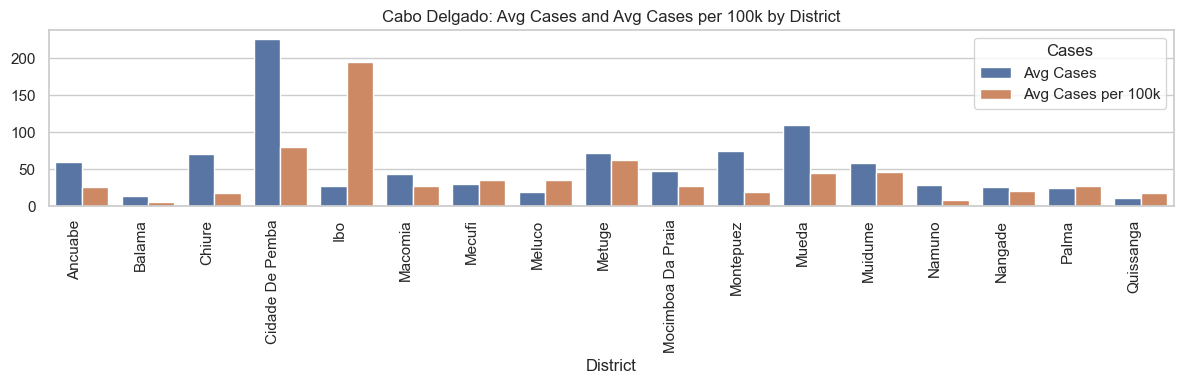

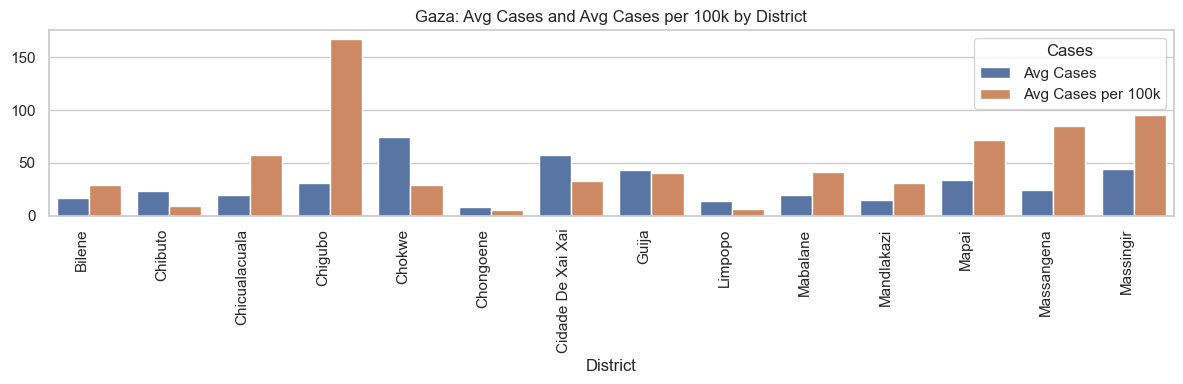

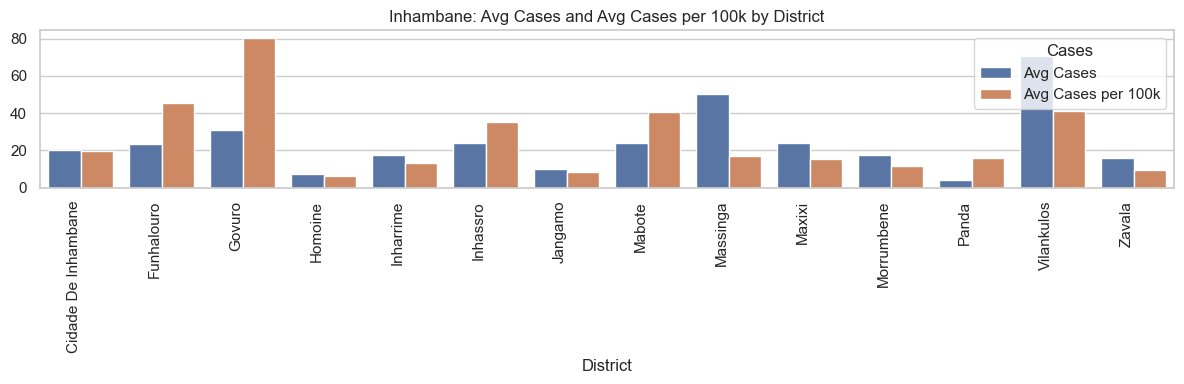

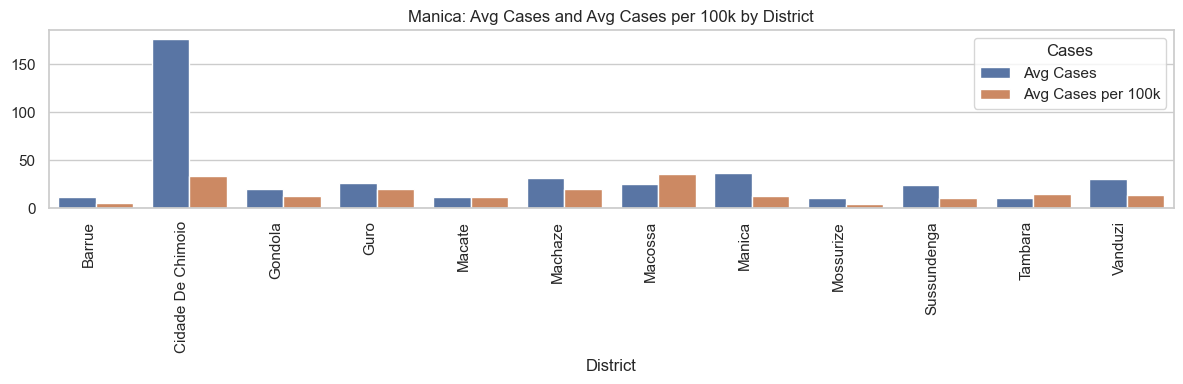

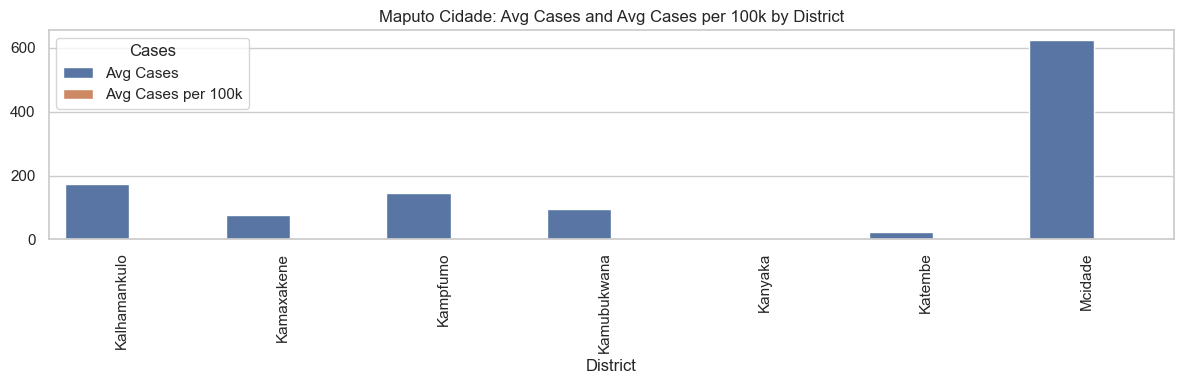

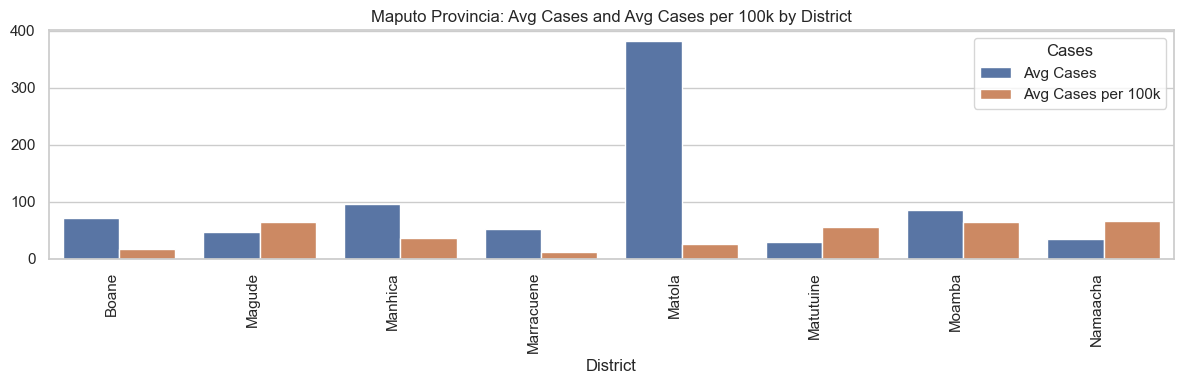

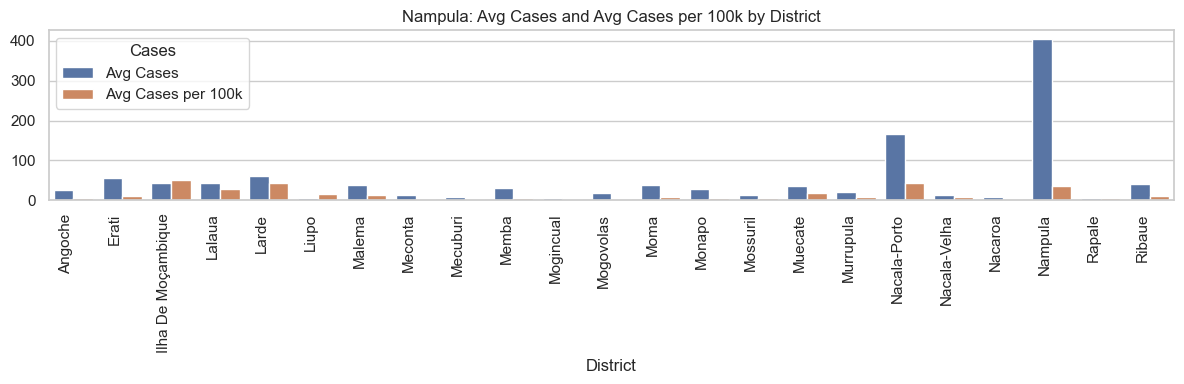

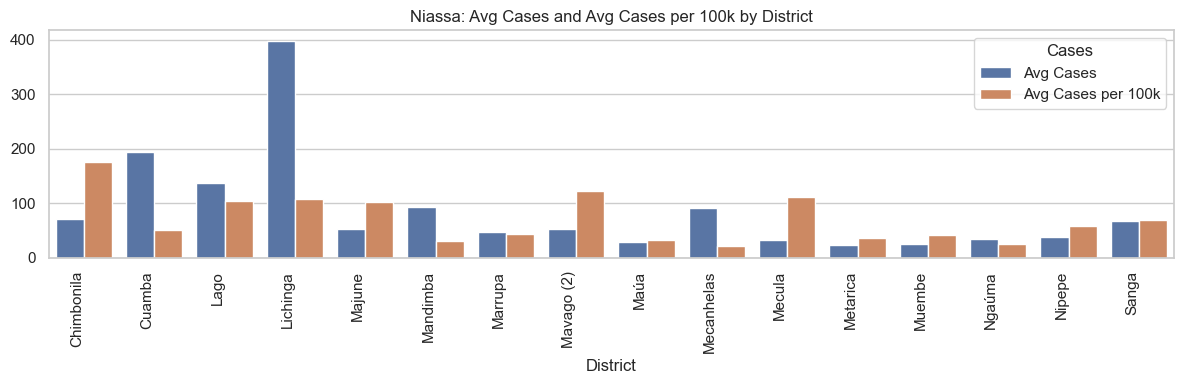

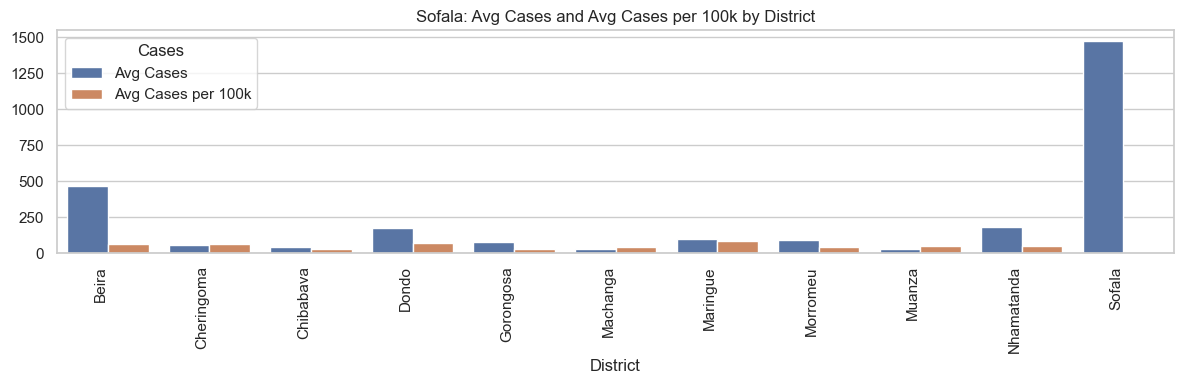

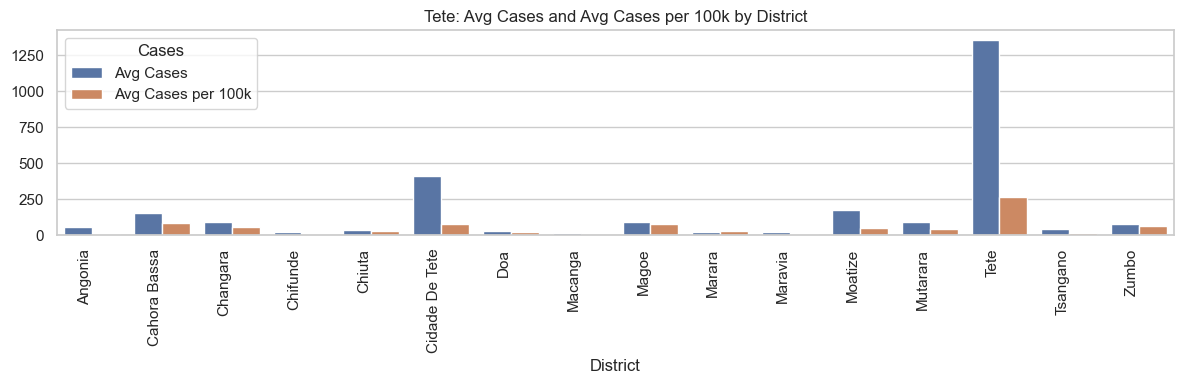

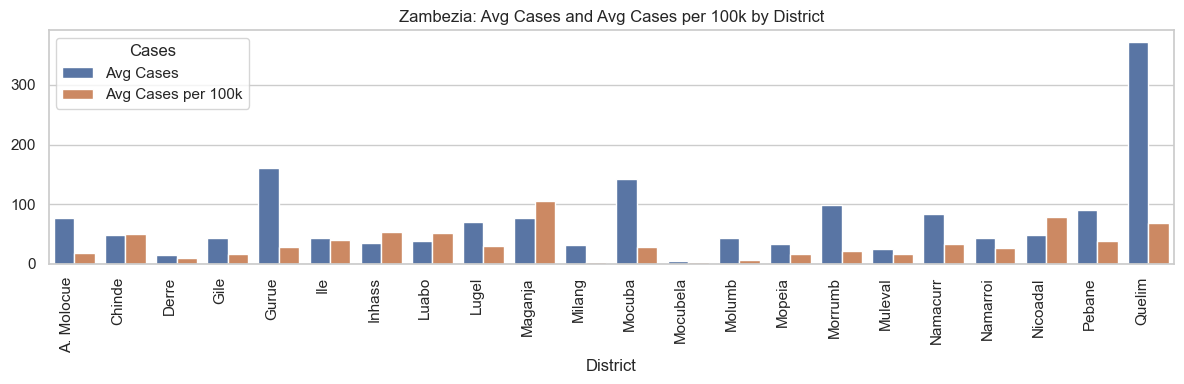

In [73]:
melted = grouped.melt(
    id_vars=["province", "district"],
    value_vars=["average_cases", "average_cases_per_100k"],
    var_name="metric",
    value_name="value",
)

# Rename for cleaner labels
melted["cases"] = melted["metric"].replace(
    {
        "average_cases": "Avg Cases",
        "average_cases_per_100k": "Avg Cases per 100k",
    }
)

# Plot
provinces = melted["province"].unique()

for province in provinces:
    df_prov = melted[melted["province"] == province]

    plt.figure(figsize=(12, 4))
    sns.barplot(
        data=df_prov,
        x="district",
        y="value",
        hue="cases",
        dodge=True,
        errorbar=None,
    )
    plt.title(f"{province}: Avg Cases and Avg Cases per 100k by District")
    plt.xlabel("District")
    plt.xticks(rotation=90, ha="right")
    plt.ylabel("")
    plt.legend(title="Cases")
    plt.tight_layout()
    plt.show()

In [74]:
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["year", "week"]].drop_duplicates().sort_values(["year", "week"])
# the number of districts by year and by province when the threshold was crossed
all_years = district_df_with_percentiles["year"].unique()
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
].groupby(["province", "year"])["district"].nunique().unstack(
    fill_value=0
).reindex(
    columns=sorted(all_years), fill_value=0
)

year              2017  2018  2019  2020  2021  2022  2023  2024  2025
province                                                              
Cabo Delgado         0     0     0     0     0     1     0     0     0
Inhambane            0     0     0     0     0     0     0     0     1
Manica               0     0     0     0     0     0     1     0     1
Maputo Provincia     0     1     1     0     0     0     0     0     0
Nampula              0     0     0     1     2     3     0     0     0
Niassa               0     1     0     0     1     2     1     0     0
Sofala               1     0     1     0     0     1     1     0     0
Tete                 0     1     1     1     0     1     1     1     1
Zambezia             0     0     0     1     1     0     1     1     0

In [75]:
# Filter if you want only the crossings
crossed_99th = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
]

district_trigger_99th = (
    crossed_99th.groupby(["province", "district", "year"])["week"]
    .count()
    .reset_index(name="week_count")
)
district_trigger_99th

province            district  year  week_count
0       Cabo Delgado                 Ibo  2022           1
1          Inhambane          Funhalouro  2025           1
2             Manica   Cidade De Chimoio  2023           5
3             Manica   Cidade De Chimoio  2025           2
4   Maputo Provincia              Magude  2018           2
5   Maputo Provincia              Magude  2019           1
6            Nampula  Ilha De Moçambique  2020           3
7            Nampula  Ilha De Moçambique  2021           6
8            Nampula  Ilha De Moçambique  2022           4
9            Nampula              Lalaua  2022           2
10           Nampula        Nacala-Porto  2021           7
11           Nampula        Nacala-Porto  2022           1
12            Niassa          Chimbonila  2018           3
13            Niassa          Chimbonila  2022           8
14            Niassa          Chimbonila  2023           1
15            Niassa              Majune  2021           1
16            Niassa          Mavago (2)  2022           1
17            Sofala               Beira  2023           3
18            Sofala            Maringue  2017           1
19            Sofala            Maringue  2019           6
20            Sofala            Maringue  2022           1
21              Tete                Tete  2018           5
22              Tete                Tete  2019           5
23              Tete                Tete  2020           3
24              Tete                Tete  2022           1
25              Tete                Tete  2023           9
26              Tete                Tete  2024           7
27              Tete                Tete  2025           6
28          Zambezia             Maganja  2020           1
29          Zambezia             Maganja  2021           3
30          Zambezia             Maganja  2024           7
31          Zambezia            Nicoadal  2023           1

In [76]:
district_df_with_percentiles[
    district_df_with_percentiles["district"].isin(
        district_trigger_99th["district"].unique()
    )
]

province district  year  week  cases district_norm     matched_name  \
45479   Sofala    Beira  2017   1.0  513.0         beira  Cidade Da Beira   
45480   Sofala    Beira  2017   2.0  517.0         beira  Cidade Da Beira   
45481   Sofala    Beira  2017   3.0  494.0         beira  Cidade Da Beira   
45482   Sofala    Beira  2017   4.0  463.0         beira  Cidade Da Beira   
45483   Sofala    Beira  2017   5.0  533.0         beira  Cidade Da Beira   
...        ...      ...   ...   ...    ...           ...              ...   
56438     Tete     Tete  2025  47.0    NaN          tete   Cidade De Tete   
56439     Tete     Tete  2025  48.0    NaN          tete   Cidade De Tete   
56440     Tete     Tete  2025  49.0    NaN          tete   Cidade De Tete   
56441     Tete     Tete  2025  50.0    NaN          tete   Cidade De Tete   
56442     Tete     Tete  2025  51.0    NaN          tete   Cidade De Tete   

            date          ADM2_PT ADM1_PT  sum_population     ADM2_PT_norm  \
45479 2017-01-02  Cidade Da Beira  Sofala       784,405.4  cidade da beira   
45480 2017-01-09  Cidade Da Beira  Sofala       784,405.4  cidade da beira   
45481 2017-01-16  Cidade Da Beira  Sofala       784,405.4  cidade da beira   
45482 2017-01-23  Cidade Da Beira  Sofala       784,405.4  cidade da beira   
45483 2017-01-30  Cidade Da Beira  Sofala       784,405.4  cidade da beira   
...          ...              ...     ...             ...              ...   
56438 2025-11-17   Cidade De Tete    Tete       505,645.7   cidade de tete   
56439 2025-11-24   Cidade De Tete    Tete       505,645.7   cidade de tete   
56440 2025-12-01   Cidade De Tete    Tete       505,645.7   cidade de tete   
56441 2025-12-08   Cidade De Tete    Tete       505,645.7   cidade de tete   
56442 2025-12-15   Cidade De Tete    Tete       505,645.7   cidade de tete   

       cases_per_100k   p99  weekly_pct_increase  above_99th  above_4x  \
45479            65.4 156.8                  NaN       False     False   
45480            65.9 156.8                  0.8       False     False   
45481            63.0 156.8                 -4.4       False     False   
45482            59.0 156.8                 -6.3       False     False   
45483            67.9 156.8                 15.1       False     False   
...               ...   ...                  ...         ...       ...   
56438             NaN 340.6                  NaN       False     False   
56439             NaN 340.6                  NaN       False     False   
56440             NaN 340.6                  NaN       False     False   
56441             NaN 340.6                  NaN       False     False   
56442             NaN 340.6                  NaN       False     False   

       threshold_crossed  three_consec_crossing  
45479              False                  False  
45480              False                  False  
45481              False                  False  
45482              False                  False  
45483              False                  False  
...                  ...                    ...  
56438              False                  False  
56439              False                  False  
56440              False                  False  
56441              False                  False  
56442              False                  False  

[5846 rows x 19 columns]

In [77]:
highlight_cells = [
    (2020, "April"),
    (2024, "January"),
]

In [78]:
month_num = {
    month: idx for idx, month in enumerate(calendar.month_name) if month
}


def highlight_month_boxes(data, cerf_y_lim="cases_per_100k", **kwargs):
    ax = plt.gca()

    # Add vertical lines
    consec_dates = data.loc[
        data["three_consec_crossing"], "date"
    ].sort_values()

    if not consec_dates.empty:
        # Convert to periods (daily)
        diffs = consec_dates.diff().dt.days.fillna(1)
        group = (diffs != 7).cumsum()  # Use 7 for weekly data

        for _, g in consec_dates.groupby(group):
            start = g.min()
            end = g.max()
            y_min = data.loc[
                (data["date"] >= start) & (data["date"] <= end),
                "cases_per_100k",
            ].min()
            y_max = data.loc[
                (data["date"] >= start) & (data["date"] <= end),
                "cases_per_100k",
            ].max()
            ax.add_patch(
                Rectangle(
                    (start, 0),
                    end - start,
                    ax.get_ylim()[1],
                    facecolor="red",
                    alpha=0.5,
                    edgecolor="red",
                )
            )

    # Highlight selected months
    for year, month in highlight_cells:
        month_index = month_num.get(month)
        if not month_index:
            continue

        mask = (data["date"].dt.year == year) & (
            data["date"].dt.month == month_index
        )
        if not mask.any():
            continue

        month_data = data.loc[mask]
        x_min = month_data["date"].min()
        x_max = month_data["date"].max()
        y_min = max(0, month_data[cerf_y_lim].min() - 5)
        y_max = month_data[cerf_y_lim].max() + 5

        ax.add_patch(
            Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                facecolor="green",
                edgecolor="green",
                alpha=0.5,
                linewidth=1,
            )
        )

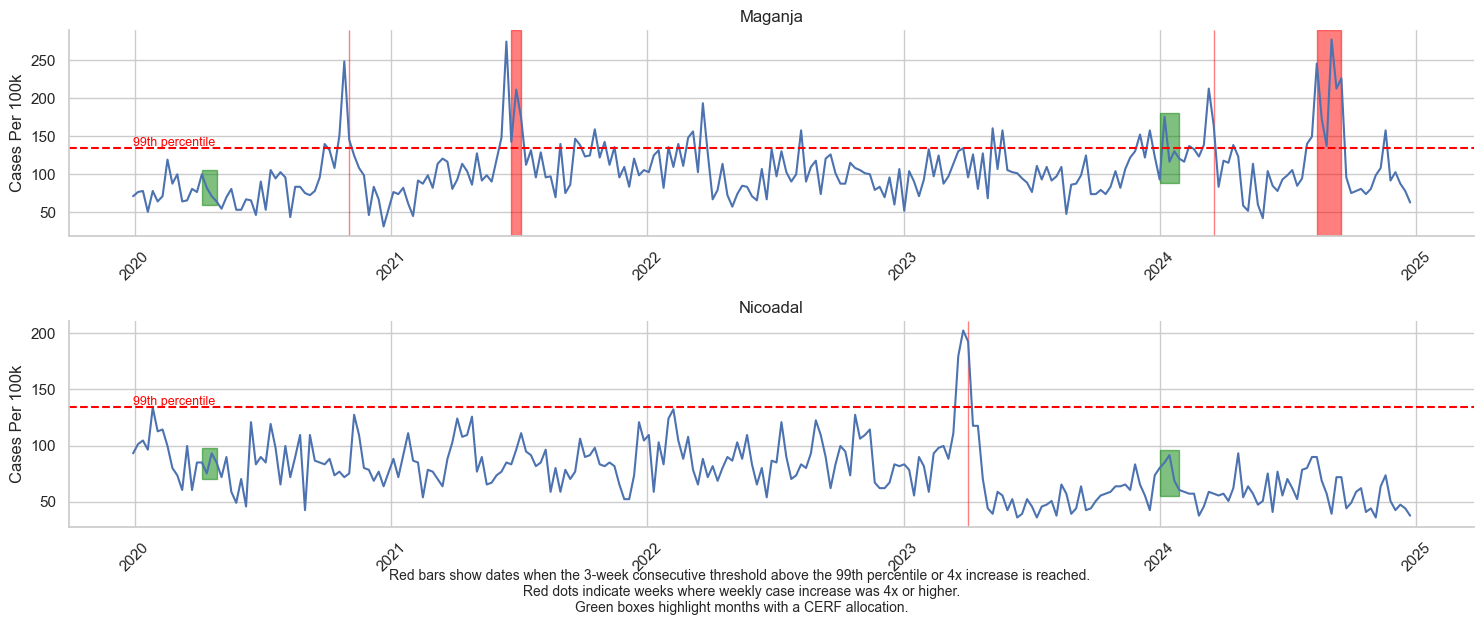

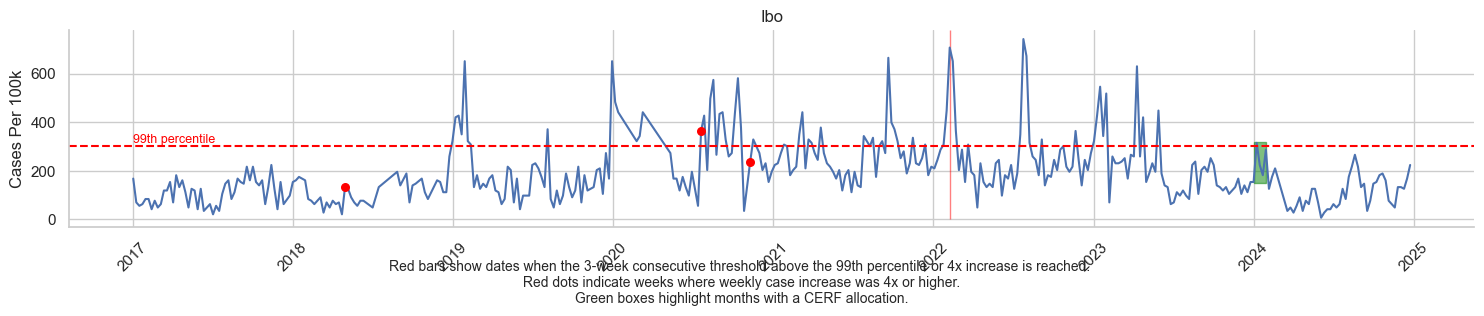

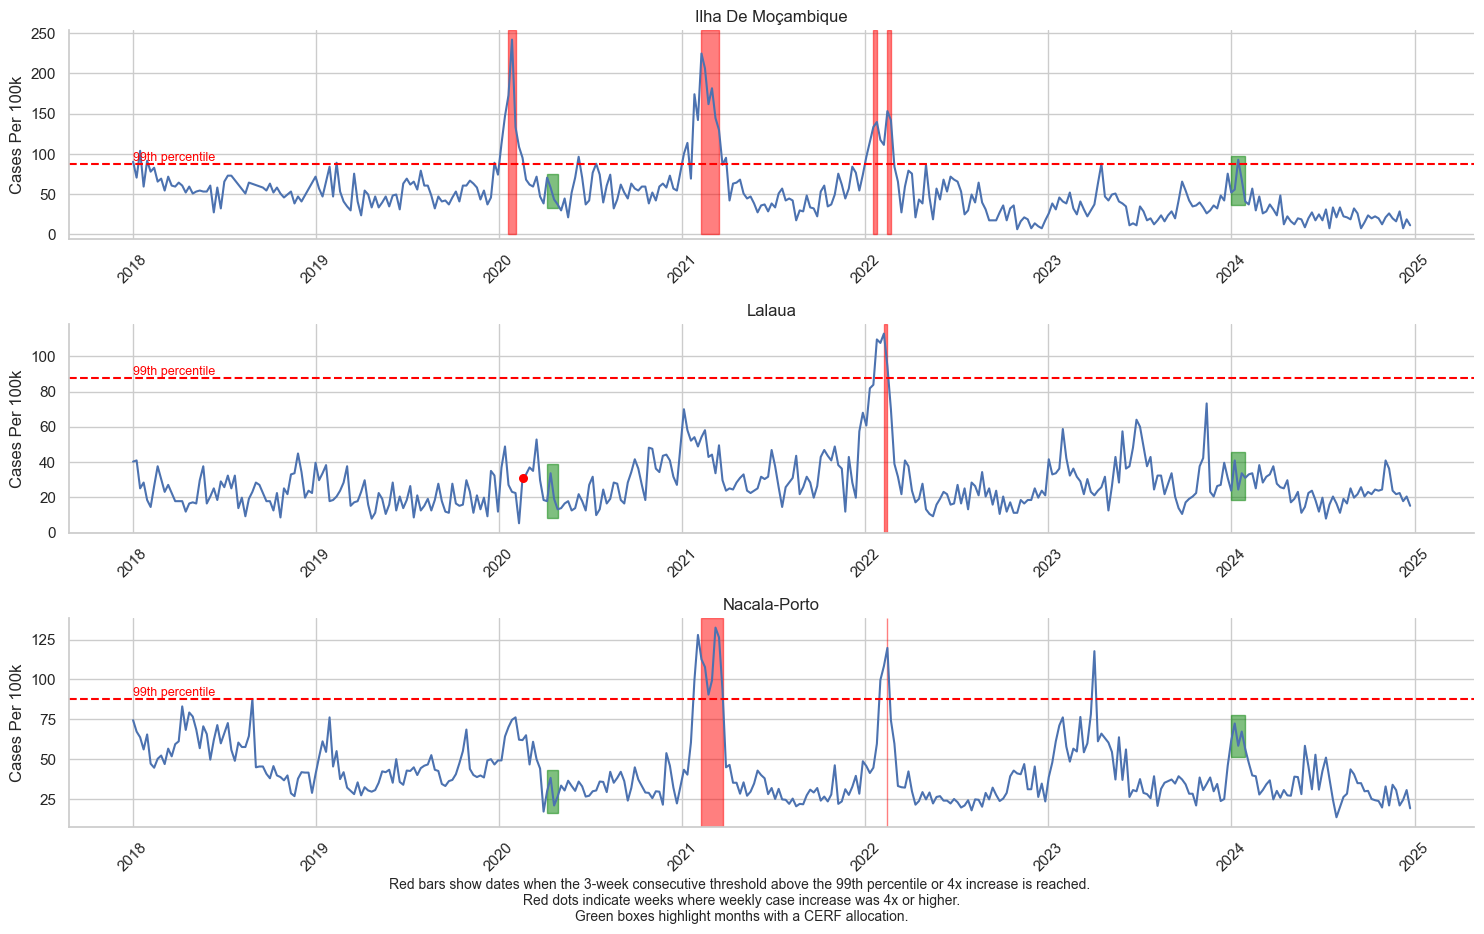

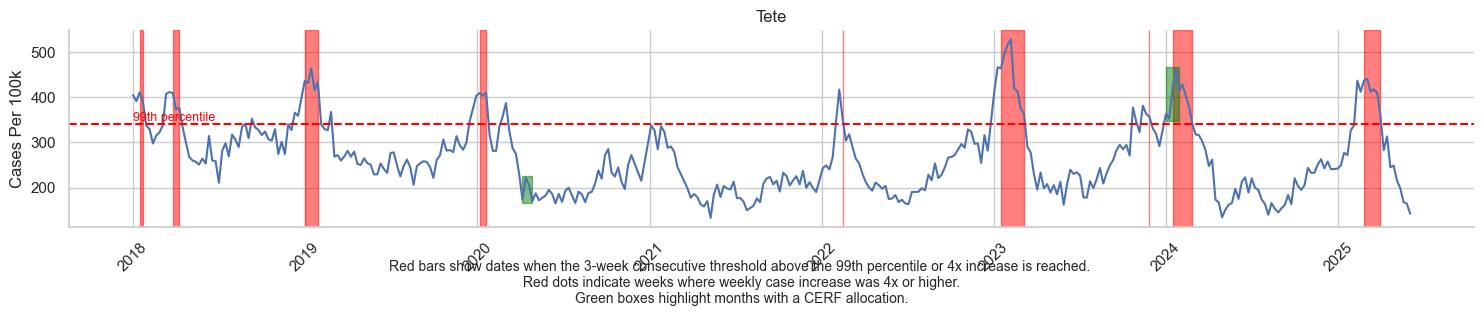

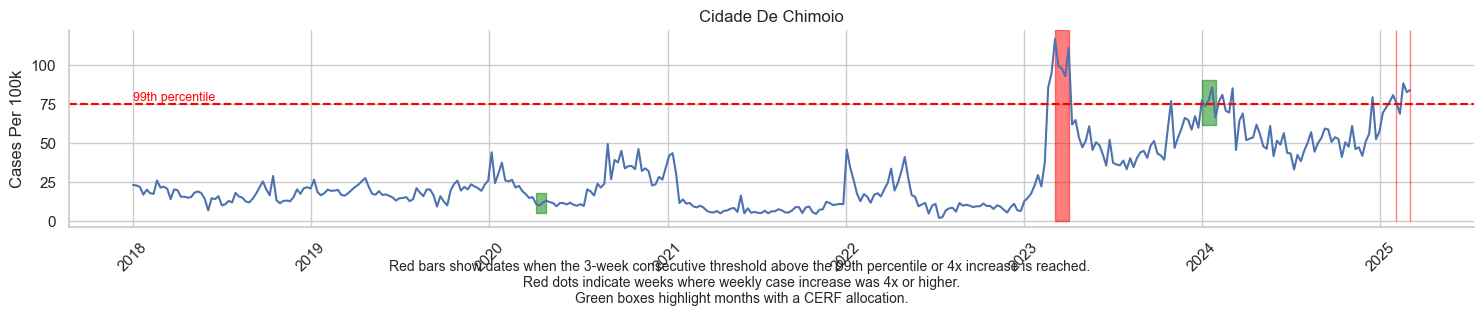

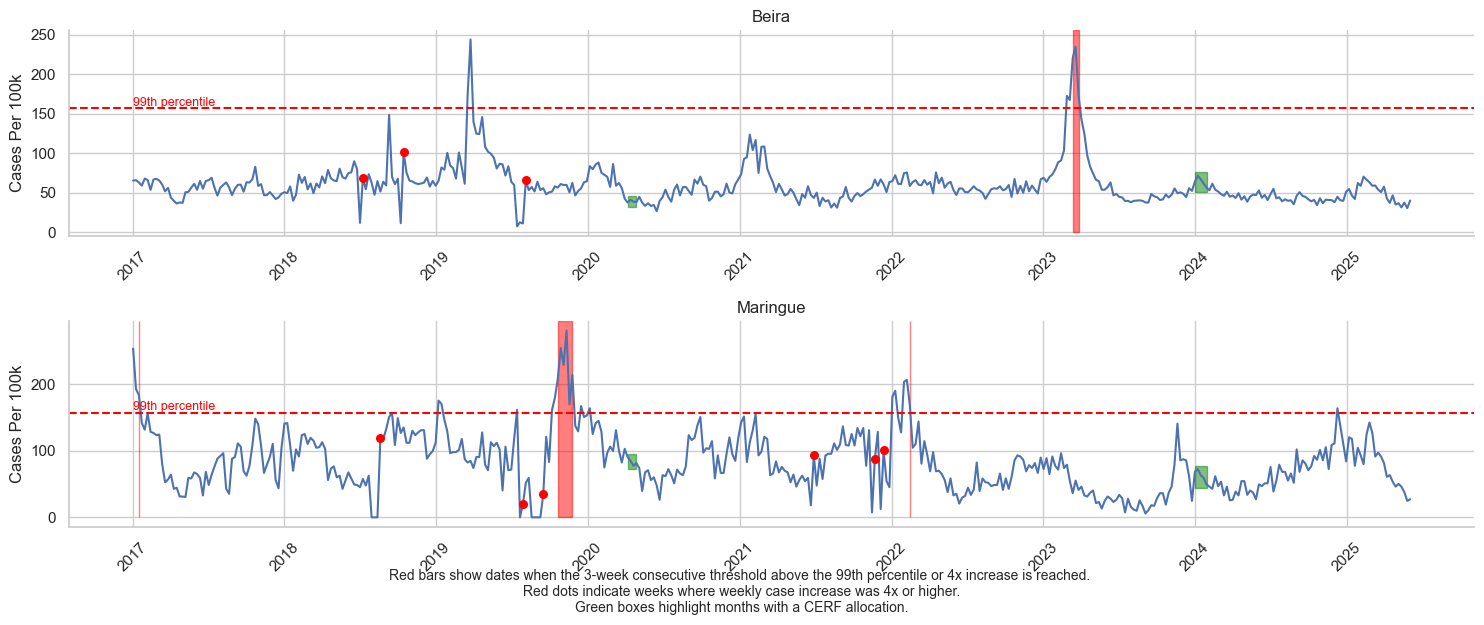

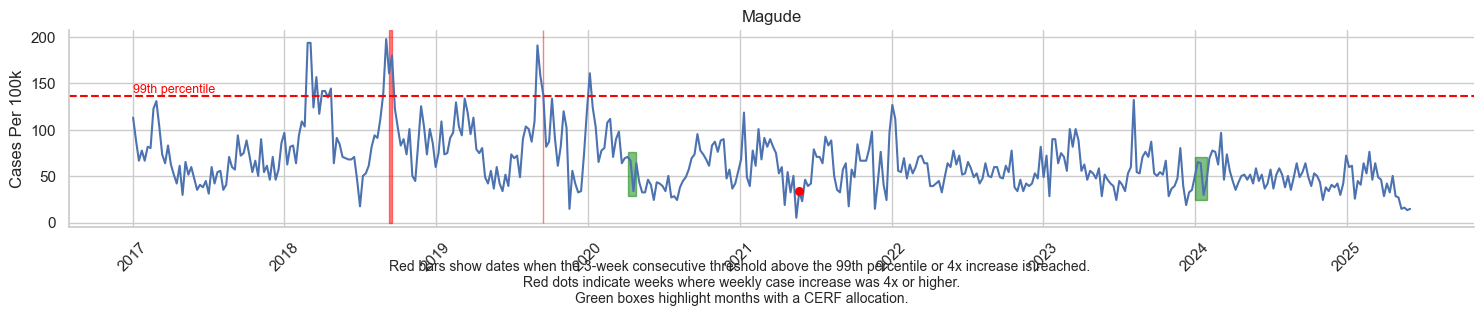

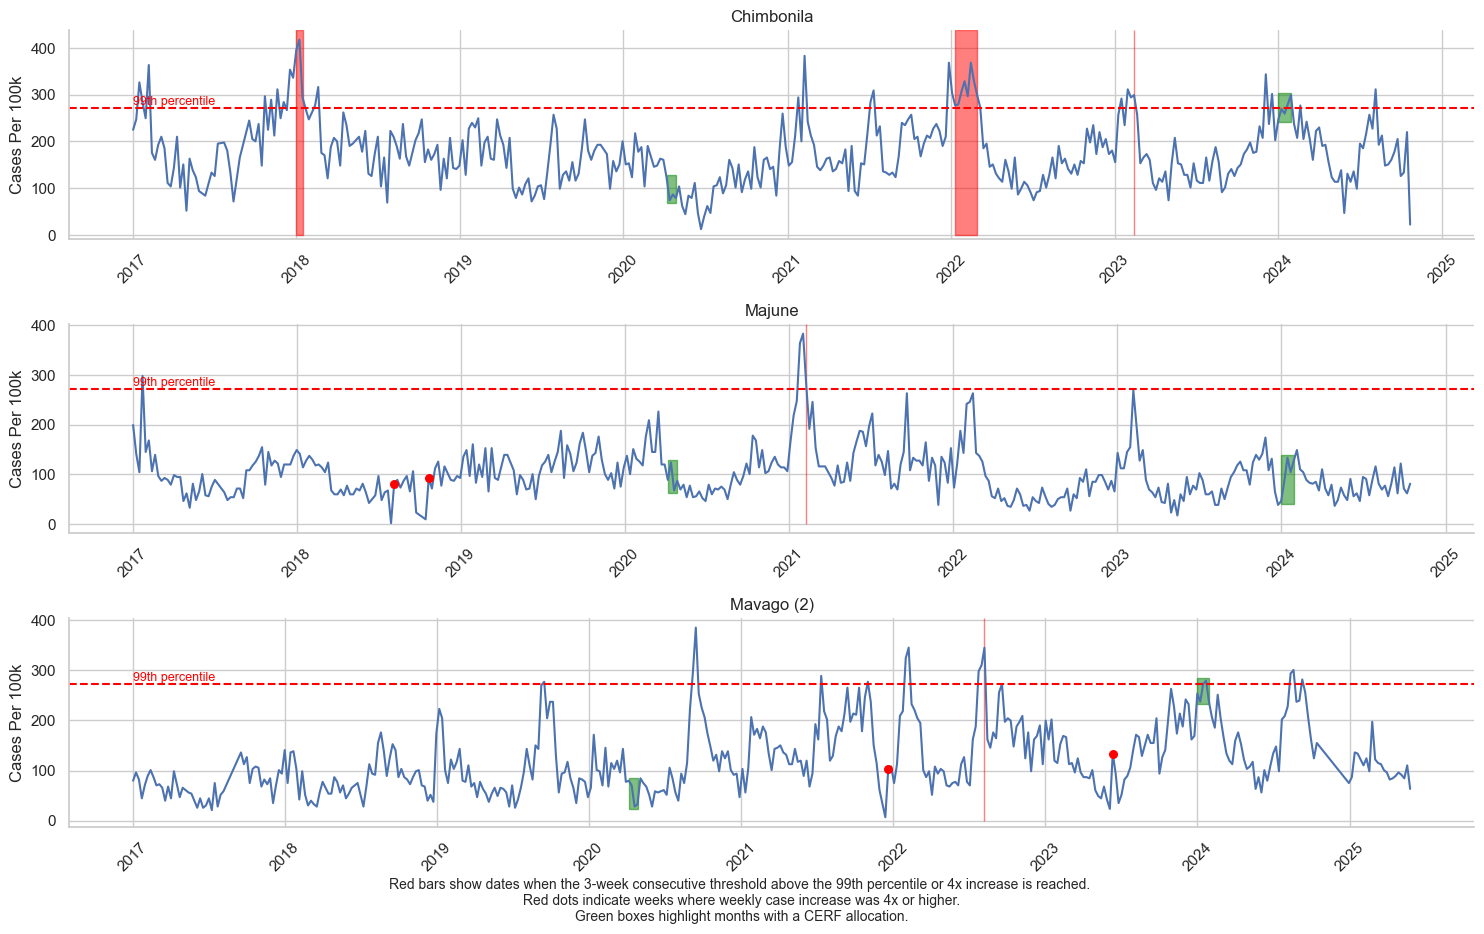

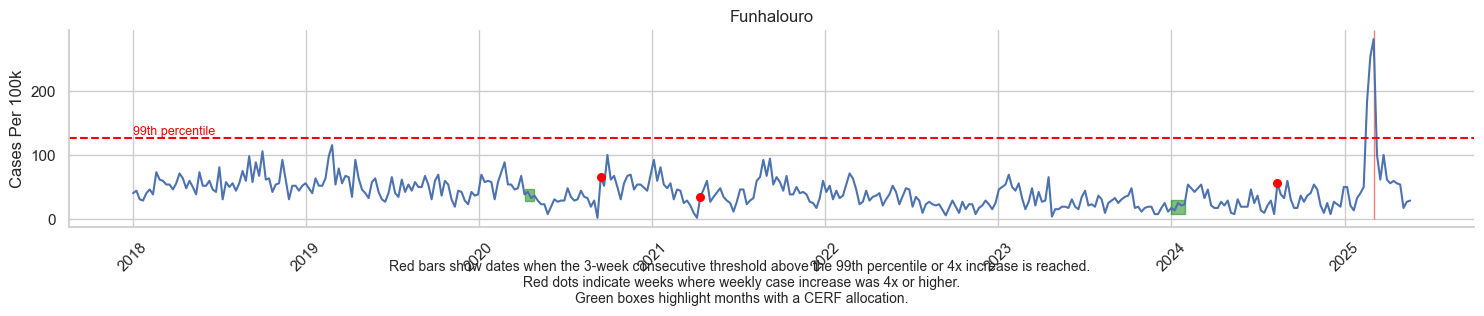

In [82]:
unique_provinces = district_df_with_percentiles["province"].unique()

for province in unique_provinces:
    subset = district_df_with_percentiles[
        (district_df_with_percentiles["province"] == province)
        & (
            district_df_with_percentiles["district"].isin(
                district_trigger_99th["district"].unique()
            )
        )
    ]

    if subset.empty:
        continue

    g = sns.FacetGrid(
        subset,
        col="district",
        col_wrap=1,
        sharex=False,
        sharey=False,
        height=3,
        aspect=5,
    )

    # Plot main line
    g.map_dataframe(sns.lineplot, x="date", y="cases_per_100k")
    # g.map_dataframe(
    #    sns.lineplot,
    #    x="date",
    #    y="cases",
    #    linestyle="--",
    #    color="orange",
    #    label="Actual Cases",
    # )

    # Add horizontal 99th percentile line
    g.map_dataframe(
        lambda data, color, **kws: (
            plt.axhline(y=data["p99"].iloc[0], color="red", linestyle="--"),
            plt.text(
                data["date"].min(),
                data["p99"].iloc[0],
                "99th percentile",
                color="red",
                fontsize=9,
                verticalalignment="bottom",
                horizontalalignment="left",
            ),
        ),
    )
    g.map_dataframe(
        lambda data, **kws: plt.scatter(
            data.loc[data["weekly_pct_increase"] >= 400, "date"],
            data.loc[data["weekly_pct_increase"] >= 400, "cases_per_100k"],
            color="red",
            s=30,
            zorder=5,
        )
    )

    # Add vertical red lines where condition is true
    def add_vertical_lines(data, **kwargs):
        for date in data.loc[data["three_consec_crossing"], "date"]:
            plt.axvline(x=date, color="red", linestyle="-", linewidth=1)

    # g.map_dataframe(add_vertical_lines)
    g.map_dataframe(highlight_month_boxes)
    g.set_titles(f"{{col_name}}")
    g.set_axis_labels("", "Cases Per 100k")

    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.tight_layout()
    plt.figtext(
        0.5,
        -0.03,
        "Red bars show dates when the 3-week consecutive threshold above the 99th percentile or 4x increase is reached. \n "
        "Red dots indicate weeks where weekly case increase was 4x or higher. \n"
        "Green boxes highlight months with a CERF allocation.",
        wrap=True,
        horizontalalignment="center",
        fontsize=10,
    )
    plt.show()

In [83]:
# showing summary by province
trigger_df = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"] == True
].copy()

# Extract month and year
trigger_df["month"] = pd.to_datetime(trigger_df["date"]).dt.month_name()
trigger_df["year"] = pd.to_datetime(trigger_df["date"]).dt.year

# Group by province, year, month
summary = (
    trigger_df.groupby(["ADM1_PT", "year", "month"])
    .agg(
        num_trigger_weeks=("week", "nunique"),
        cases_per_100k=("cases_per_100k", "first"),
        districts=("district", lambda x: ", ".join(sorted(set(x)))),
    )
    .reset_index()
    .rename(columns={"ADM1_PT": "province"})
    .sort_values(["province", "year", "month"])
)
summary

province  year      month  num_trigger_weeks  cases_per_100k  \
0   Cabo Delgado  2022   February                  1           707.6   
1      Inhambane  2025      March                  1           281.8   
2         Manica  2023      April                  1           111.1   
3         Manica  2023      March                  4           116.6   
4         Manica  2025   February                  1            75.6   
5         Manica  2025      March                  1            84.0   
6         Maputo  2018  September                  2           160.8   
7         Maputo  2019  September                  1           137.6   
8        Nampula  2020   February                  1           133.3   
9        Nampula  2020    January                  2           172.8   
10       Nampula  2021   February                  3           224.7   
11       Nampula  2021      March                  4           181.5   
12       Nampula  2022   February                  3           153.1   
13       Nampula  2022    January                  2           133.3   
14        Niassa  2018    January                  3           395.4   
15        Niassa  2021   February                  1           280.5   
16        Niassa  2022     August                  1           345.3   
17        Niassa  2022   February                  4           296.6   
18        Niassa  2022    January                  4           276.8   
19        Niassa  2023   February                  1           299.1   
20        Sofala  2017    January                  1           183.7   
21        Sofala  2019   November                  4           229.0   
22        Sofala  2019    October                  2           208.4   
23        Sofala  2022   February                  1           168.8   
24        Sofala  2023      March                  3           220.4   
25          Tete  2018      April                  2           373.6   
26          Tete  2018   December                  1           436.3   
27          Tete  2018    January                  2           411.2   
28          Tete  2018      March                  1           409.6   
29          Tete  2019    January                  4           431.7   
30          Tete  2020    January                  3           409.4   
31          Tete  2022   February                  1           353.0   
32          Tete  2023   February                  4           528.8   
33          Tete  2023    January                  3           464.2   
34          Tete  2023      March                  1           363.7   
35          Tete  2023   November                  1           356.8   
36          Tete  2024   February                  4           428.0   
37          Tete  2024    January                  3           418.7   
38          Tete  2025   February                  1           437.1   
39          Tete  2025      March                  5           441.0   
40      Zambezia  2020   November                  1           145.4   
41      Zambezia  2021       July                  1           174.2   
42      Zambezia  2021       June                  2           142.7   
43      Zambezia  2023      April                  1           192.7   
44      Zambezia  2024     August                  3           245.6   
45      Zambezia  2024      March                  1           164.6   
46      Zambezia  2024  September                  3           277.1   

                                   districts  
0                                        Ibo  
1                                 Funhalouro  
2                          Cidade De Chimoio  
3                          Cidade De Chimoio  
4                          Cidade De Chimoio  
5                          Cidade De Chimoio  
6                                     Magude  
7                                     Magude  
8                         Ilha De Moçambique  
9                         Ilha De Moçambique  
10          Ilha De Moçambique, Na

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\4277793335.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = summary.pivot_table(


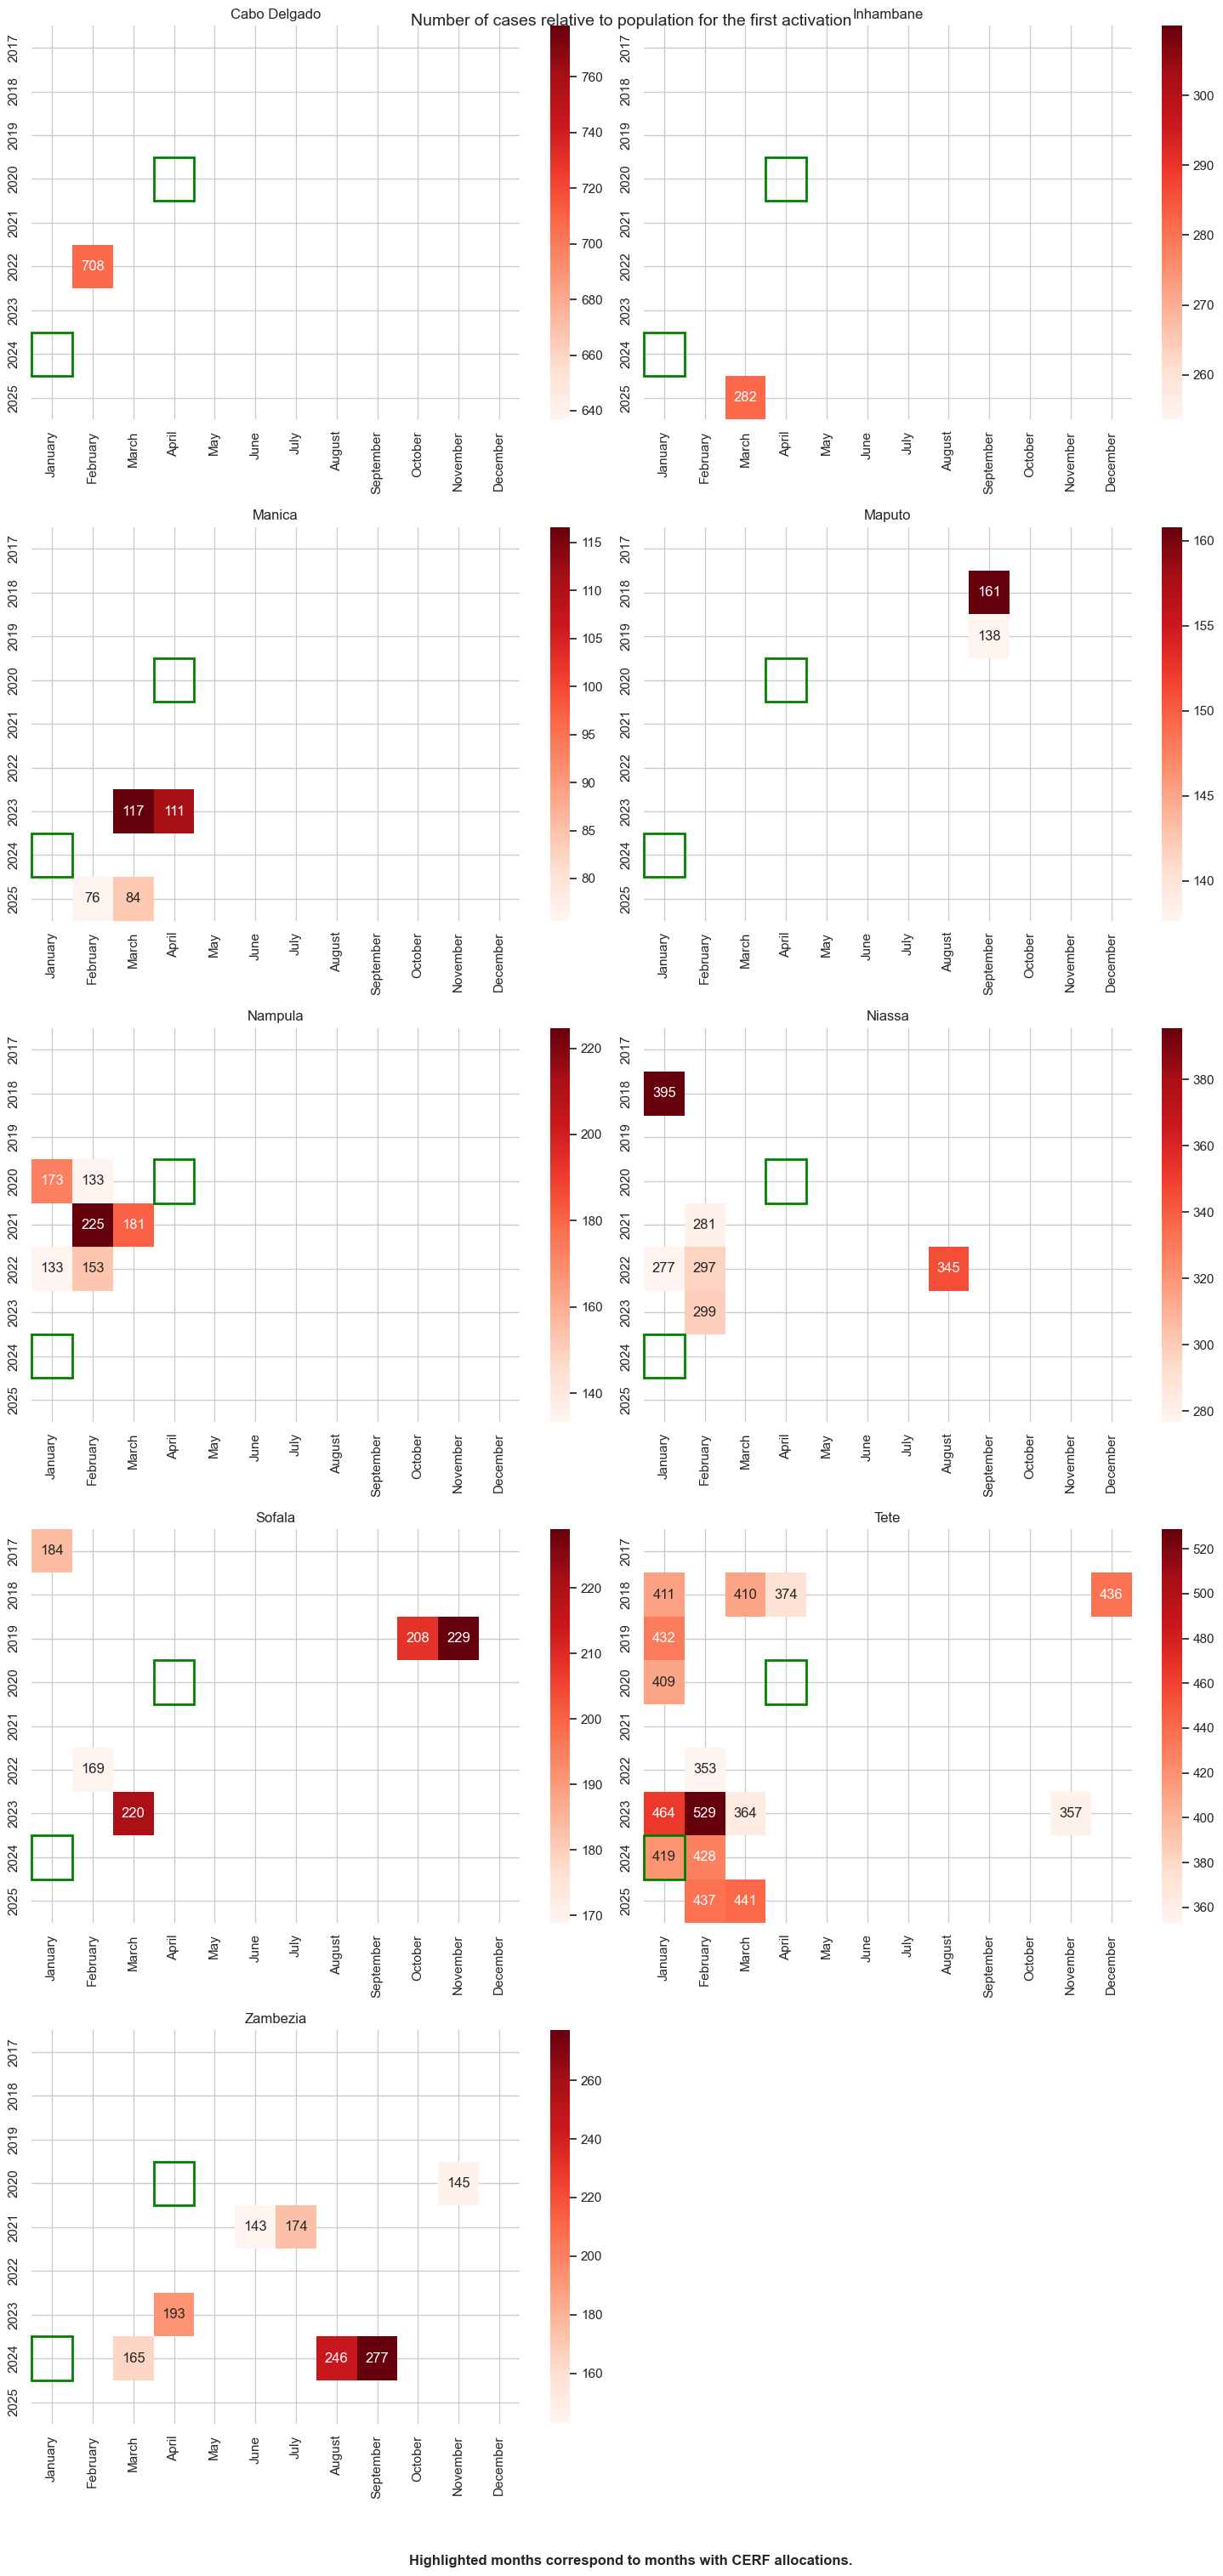

In [84]:
# Ensure months are ordered
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
summary["month"] = pd.Categorical(
    summary["month"], categories=month_order, ordered=True
)

# Pivot the data
pivot = summary.pivot_table(
    values="cases_per_100k", index="year", columns="month", aggfunc="first"
).sort_index()

all_years = list(range(summary["year"].min(), summary["year"].max() + 1))

# Faceted heatmap
g = sns.FacetGrid(
    summary,
    col="province",
    col_wrap=2,
    height=6,
    aspect=1.25,
    sharex=False,
    sharey=False,
)


def heatmap_with_all_years(data, **kwargs):
    table = data.pivot_table(
        index="year",
        columns="month",
        values="cases_per_100k",
        aggfunc="first",
        observed=False,
    ).reindex(index=all_years, columns=month_order)

    sns.heatmap(
        table,
        cmap="Reds",
        cbar=True,
        annot=True,
        fmt=".0f",
        linewidths=0,
        linecolor=None,
    )
    ax = plt.gca()

    # Outline targets
    highlight_cells = [
        (2020, "April"),
        (2024, "January"),
    ]

    # Loop and draw rectangles
    for year, month in highlight_cells:
        try:
            row_idx = table.index.get_loc(year)
            col_idx = table.columns.get_loc(month)
            ax.add_patch(
                plt.Rectangle(
                    (col_idx, row_idx),
                    1,
                    1,
                    fill=False,
                    edgecolor="green",
                    linewidth=2,
                    clip_on=False,
                )
            )
        except KeyError:
            continue


g.map_dataframe(heatmap_with_all_years)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle(
    "Number of cases relative to population for the first activation",
    fontsize=14,
)
plt.figtext(
    0.5,
    -0.02,
    "Highlighted months correspond to months with CERF allocations.",
    ha="center",
    fontsize=12,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [85]:
summary["district_count"] = (
    summary["districts"]
    .str.split(",")
    .apply(lambda x: len([d.strip() for d in x if d.strip()]))
)
summary

province  year      month  num_trigger_weeks  cases_per_100k  \
0   Cabo Delgado  2022   February                  1           707.6   
1      Inhambane  2025      March                  1           281.8   
2         Manica  2023      April                  1           111.1   
3         Manica  2023      March                  4           116.6   
4         Manica  2025   February                  1            75.6   
5         Manica  2025      March                  1            84.0   
6         Maputo  2018  September                  2           160.8   
7         Maputo  2019  September                  1           137.6   
8        Nampula  2020   February                  1           133.3   
9        Nampula  2020    January                  2           172.8   
10       Nampula  2021   February                  3           224.7   
11       Nampula  2021      March                  4           181.5   
12       Nampula  2022   February                  3           153.1   
13       Nampula  2022    January                  2           133.3   
14        Niassa  2018    January                  3           395.4   
15        Niassa  2021   February                  1           280.5   
16        Niassa  2022     August                  1           345.3   
17        Niassa  2022   February                  4           296.6   
18        Niassa  2022    January                  4           276.8   
19        Niassa  2023   February                  1           299.1   
20        Sofala  2017    January                  1           183.7   
21        Sofala  2019   November                  4           229.0   
22        Sofala  2019    October                  2           208.4   
23        Sofala  2022   February                  1           168.8   
24        Sofala  2023      March                  3           220.4   
25          Tete  2018      April                  2           373.6   
26          Tete  2018   December                  1           436.3   
27          Tete  2018    January                  2           411.2   
28          Tete  2018      March                  1           409.6   
29          Tete  2019    January                  4           431.7   
30          Tete  2020    January                  3           409.4   
31          Tete  2022   February                  1           353.0   
32          Tete  2023   February                  4           528.8   
33          Tete  2023    January                  3           464.2   
34          Tete  2023      March                  1           363.7   
35          Tete  2023   November                  1           356.8   
36          Tete  2024   February                  4           428.0   
37          Tete  2024    January                  3           418.7   
38          Tete  2025   February                  1           437.1   
39          Tete  2025      March                  5           441.0   
40      Zambezia  2020   November                  1           145.4   
41      Zambezia  2021       July                  1           174.2   
42      Zambezia  2021       June                  2           142.7   
43      Zambezia  2023      April                  1           192.7   
44      Zambezia  2024     August                  3           245.6   
45      Zambezia  2024      March                  1           164.6   
46      Zambezia  2024  September                  3           277.1   

                                   districts  district_count  
0                                        Ibo               1  
1                                 Funhalouro               1  
2                          Cidade De Chimoio               1  
3                          Cidade De Chimoio               1  
4                          Cidade De Chimoio               1  
5                          Cidade De Chimoio               1  
6                                     Magude               1  
7                                     Magude   

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\3042117975.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_dist = summary.pivot_table(


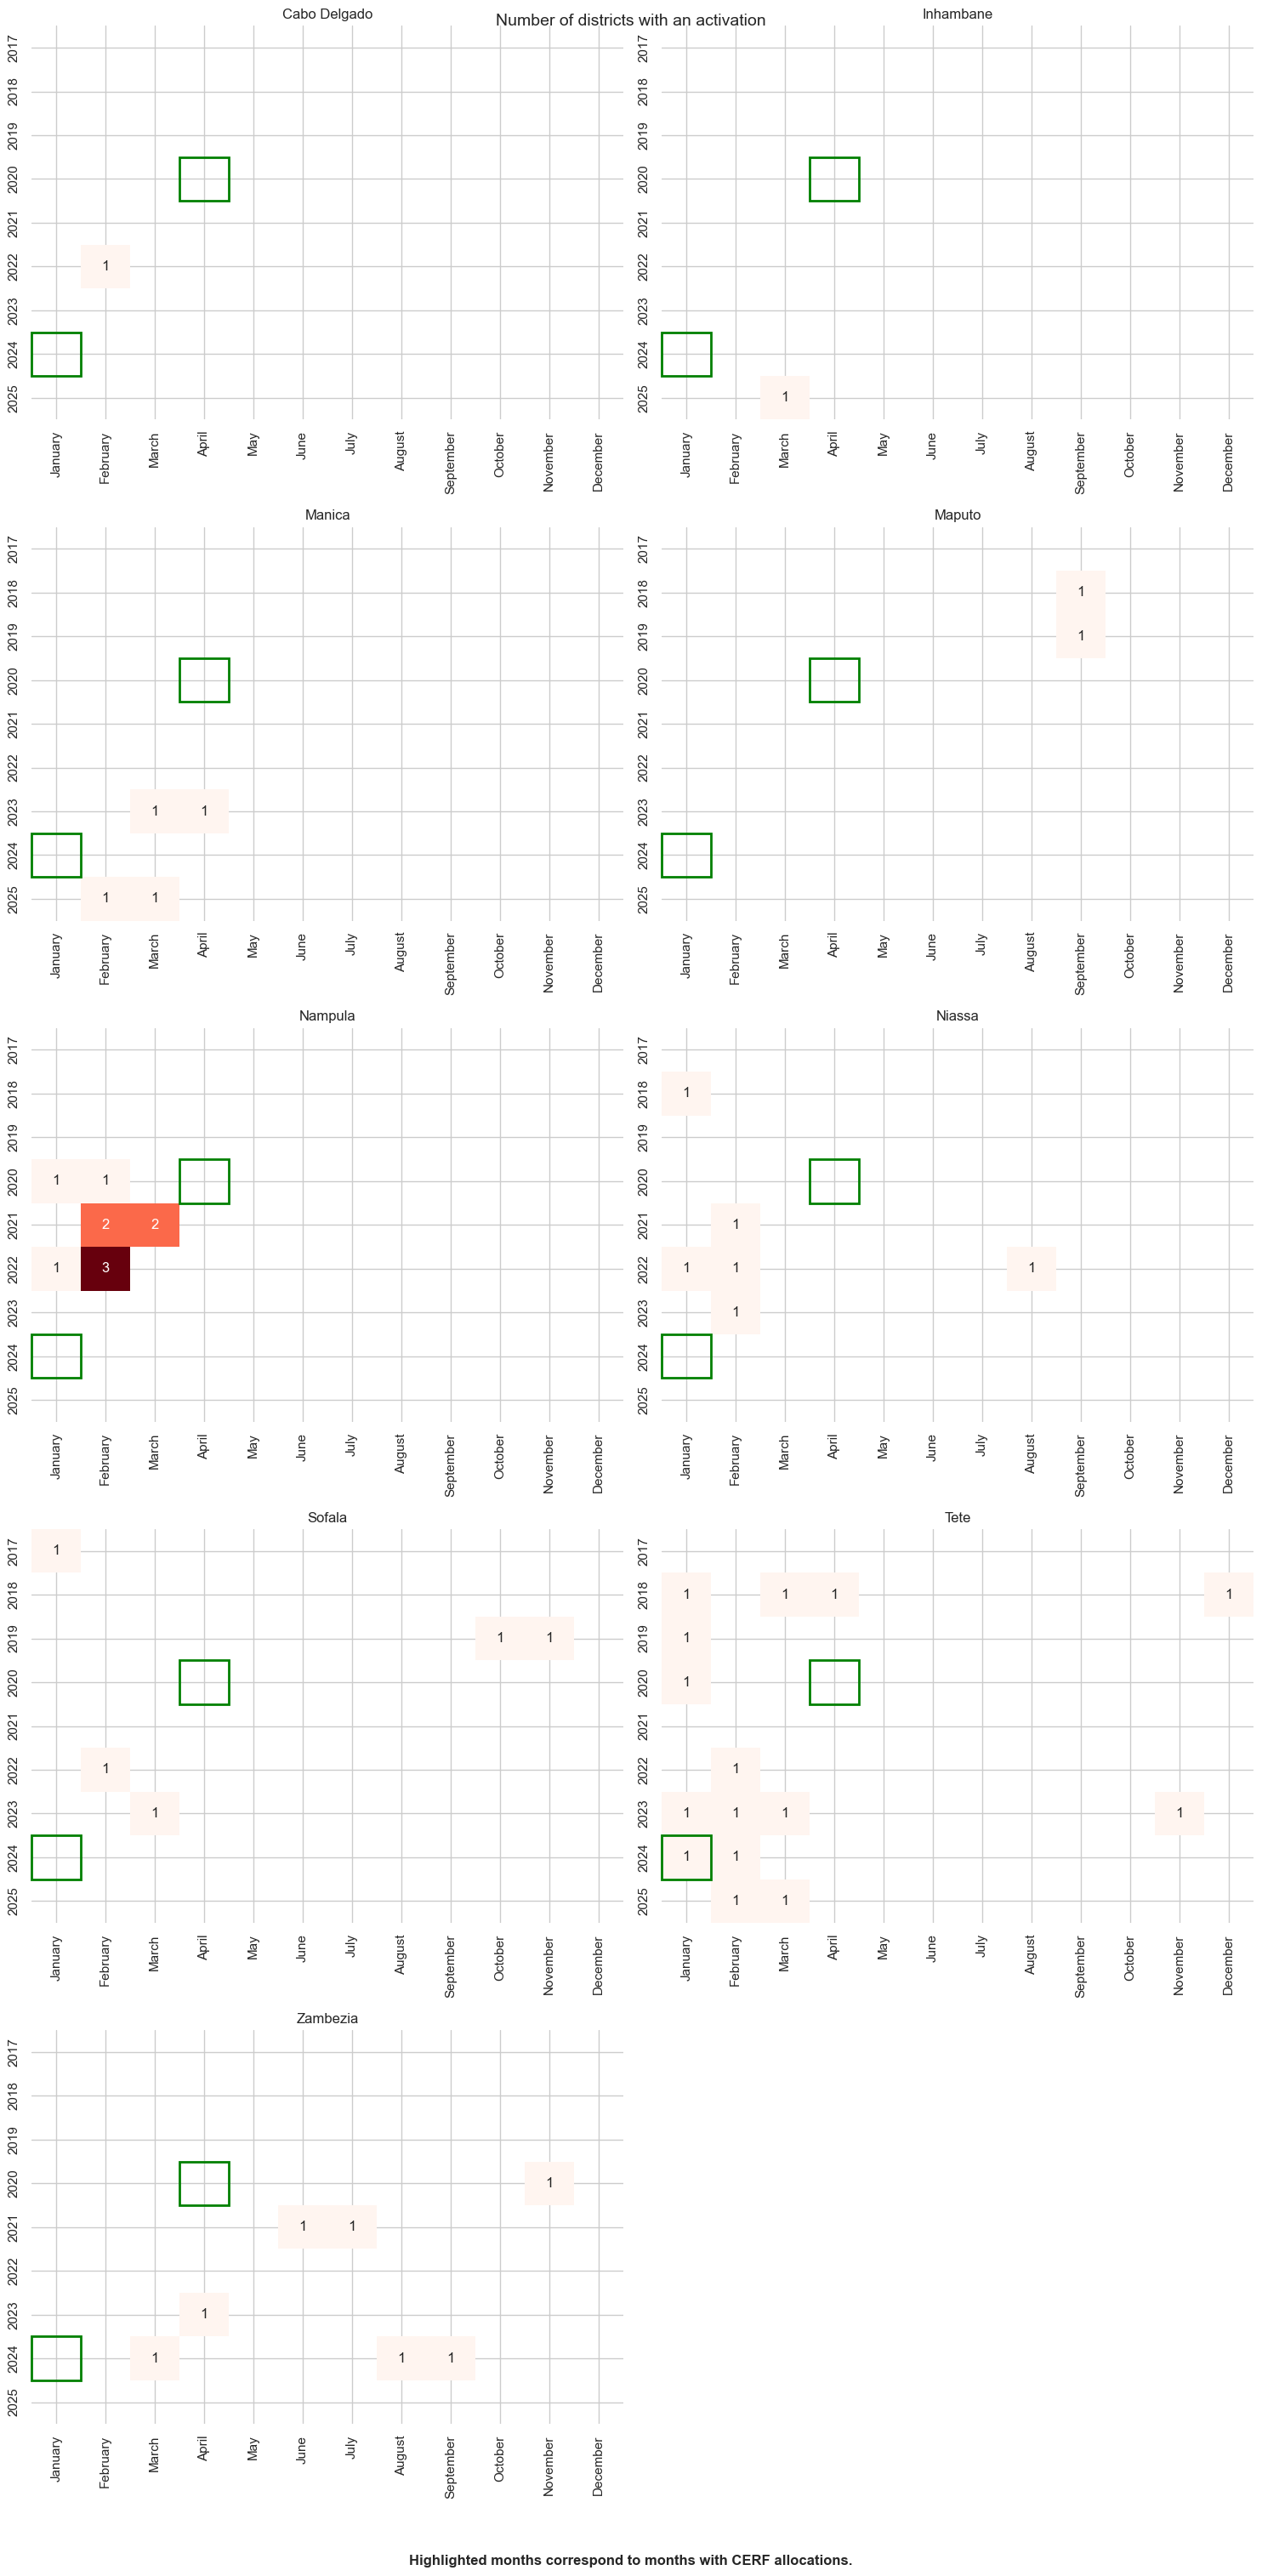

In [86]:
# Pivot the data
pivot_dist = summary.pivot_table(
    values="district_count", index="year", columns="month", aggfunc="mean"
).sort_index()

all_years = list(range(summary["year"].min(), summary["year"].max() + 1))

# Faceted heatmap
g = sns.FacetGrid(
    summary,
    col="province",
    col_wrap=2,
    height=6,
    aspect=1.25,
    sharex=False,
    sharey=False,
)


def heatmap_with_all_years(data, **kwargs):
    table = data.pivot_table(
        index="year",
        columns="month",
        values="district_count",
        aggfunc="first",
        observed=False,
    ).reindex(index=all_years, columns=month_order)

    sns.heatmap(
        table,
        cmap="Reds",
        cbar=False,
        annot=True,
        fmt=".0f",
        linewidths=0,
        linecolor=None,
    )
    ax = plt.gca()

    # Outline targets
    highlight_cells = [
        (2020, "April"),
        (2024, "January"),
    ]

    # Loop and draw rectangles
    for year, month in highlight_cells:
        try:
            row_idx = table.index.get_loc(year)
            col_idx = table.columns.get_loc(month)
            ax.add_patch(
                plt.Rectangle(
                    (col_idx, row_idx),
                    1,
                    1,
                    fill=False,
                    edgecolor="green",
                    linewidth=2,
                    clip_on=False,
                )
            )
        except KeyError:
            continue


g.map_dataframe(heatmap_with_all_years)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle(
    "Number of districts with an activation",
    fontsize=14,
)
plt.figtext(
    0.5,
    -0.02,
    "Highlighted months correspond to months with CERF allocations.",
    ha="center",
    fontsize=12,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


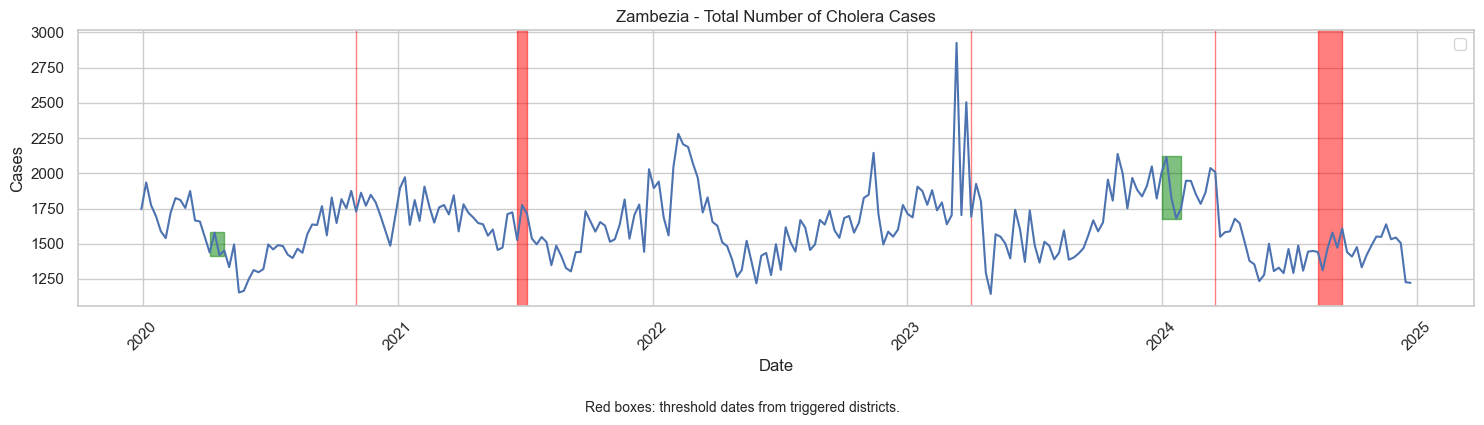

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


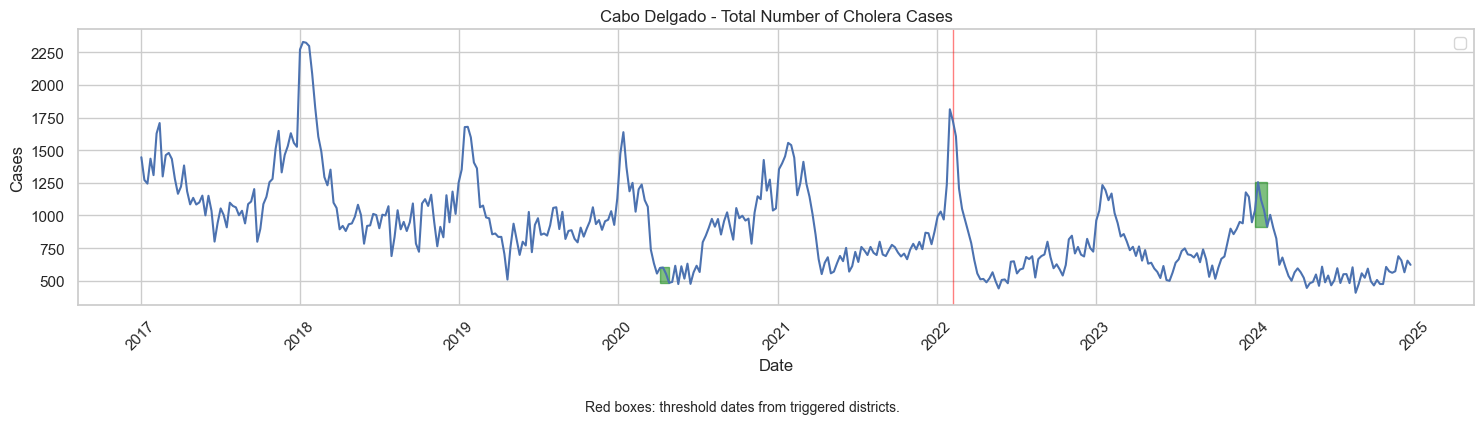

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


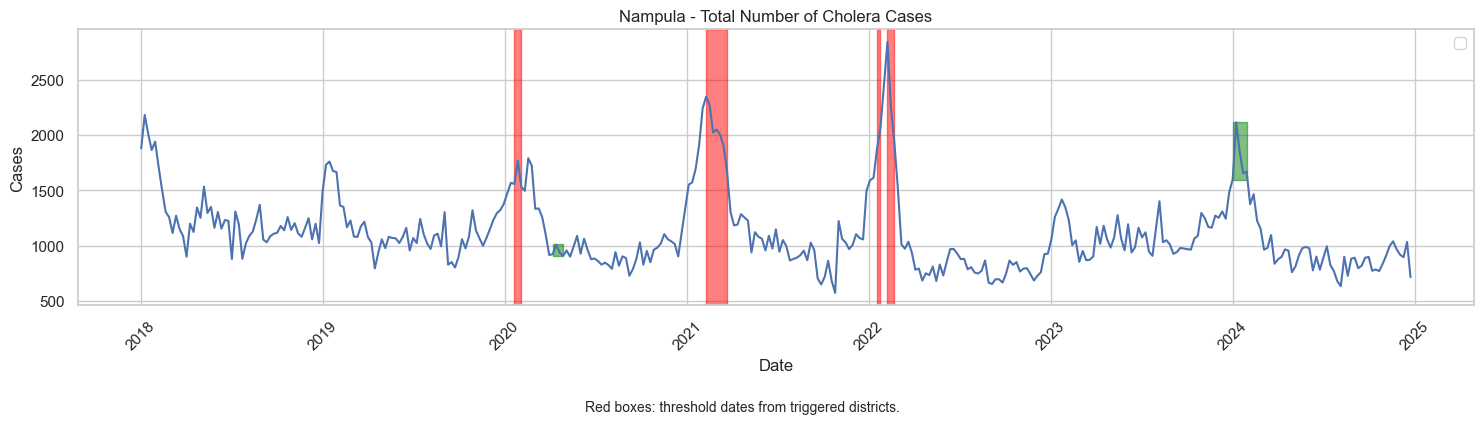

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


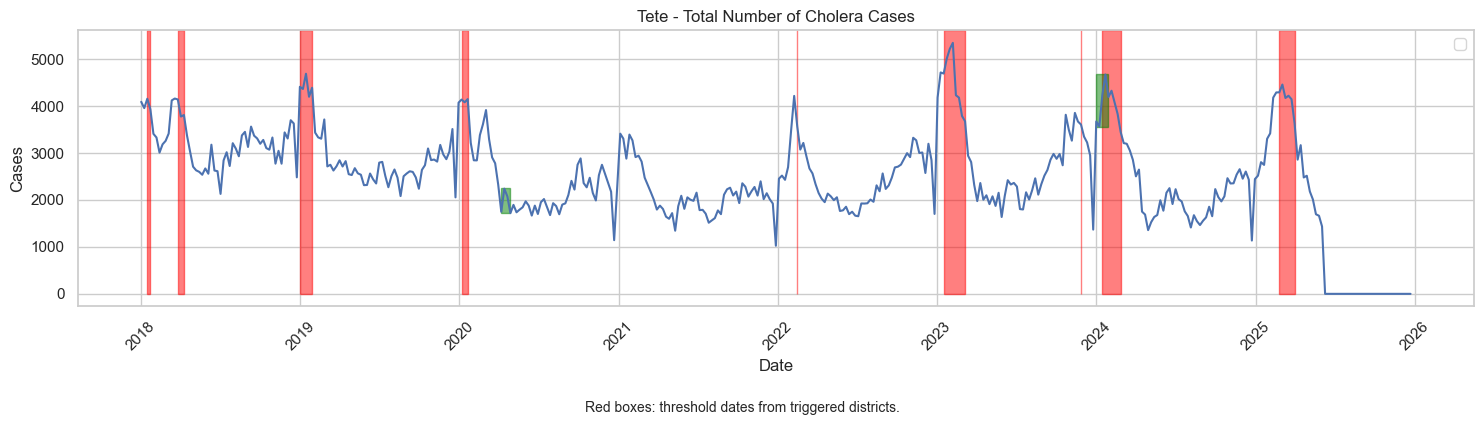

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


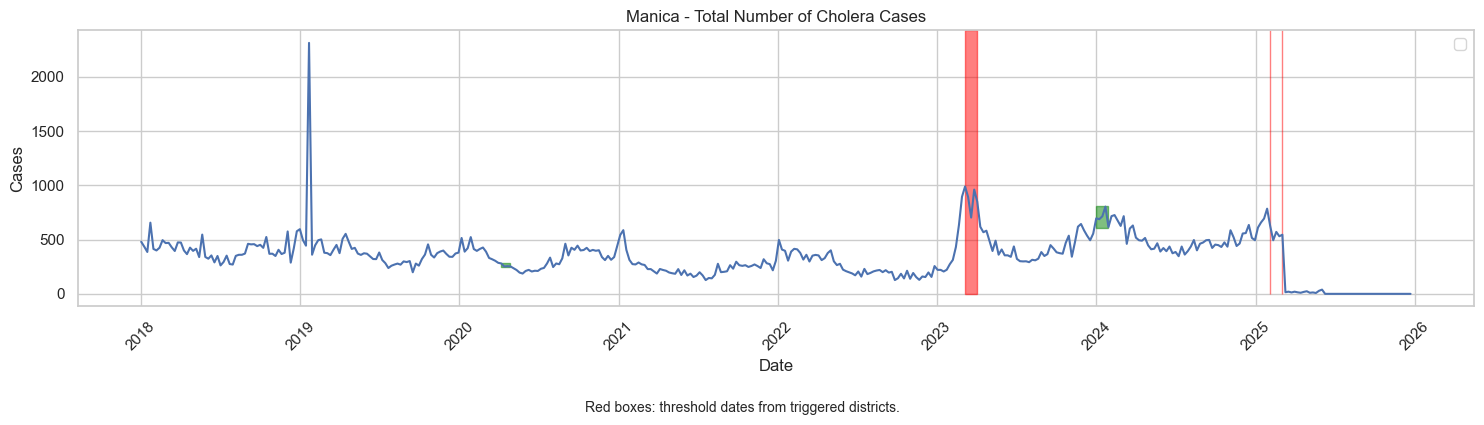

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


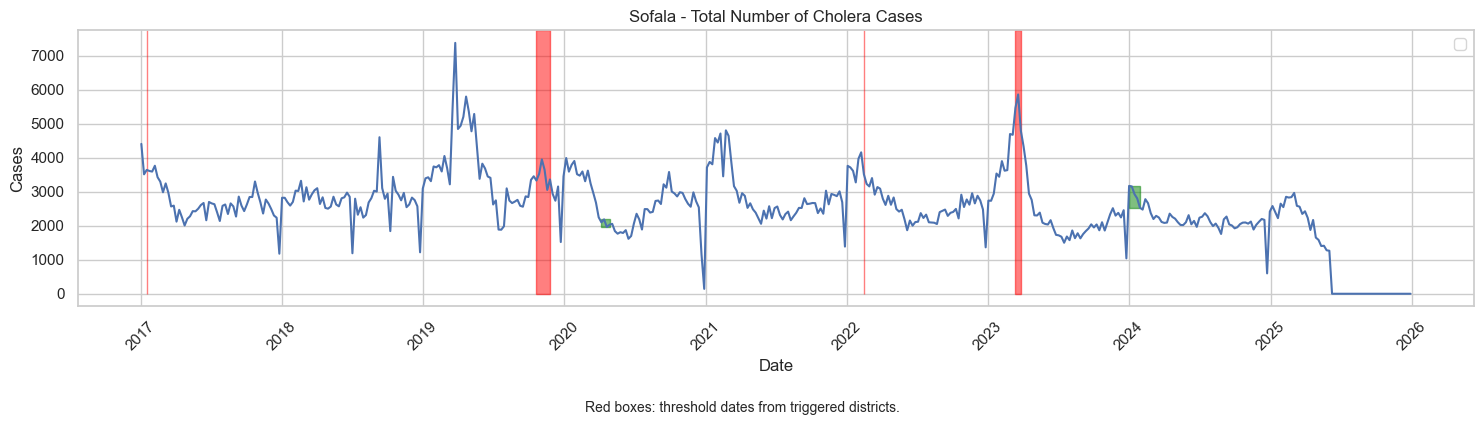

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


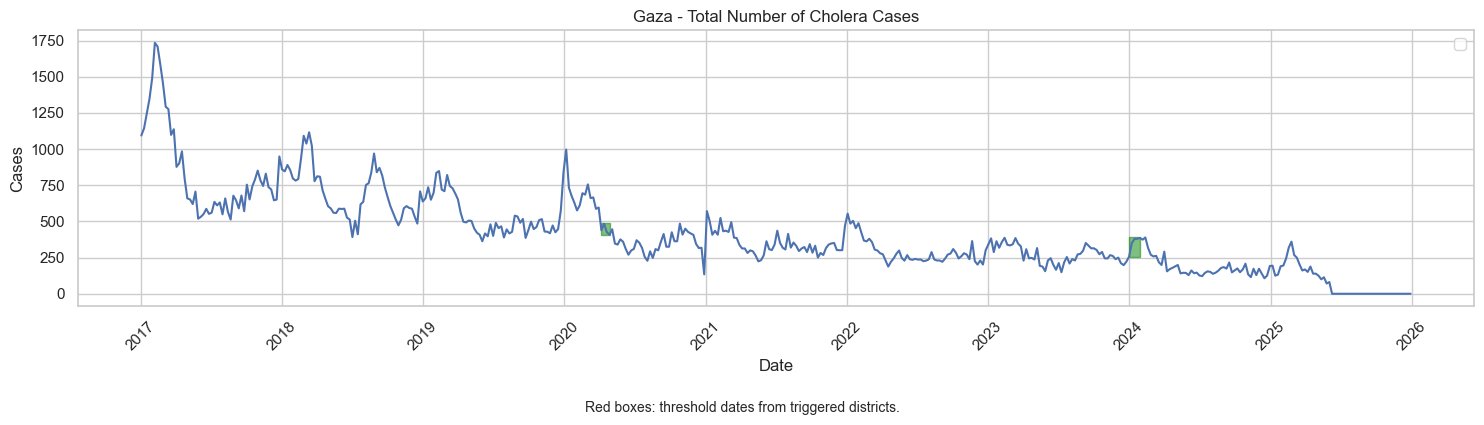

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


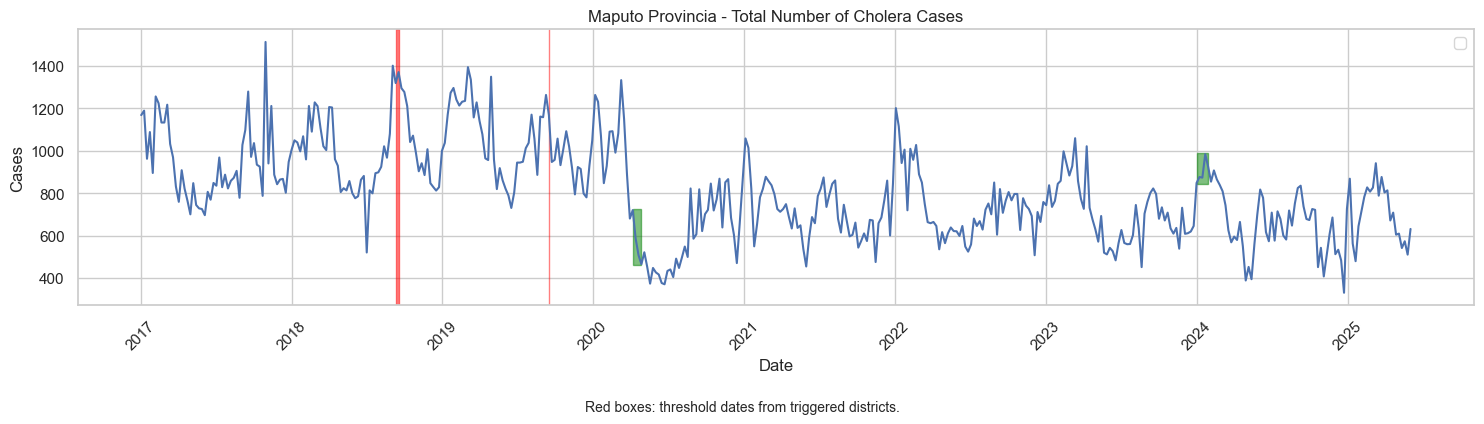

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


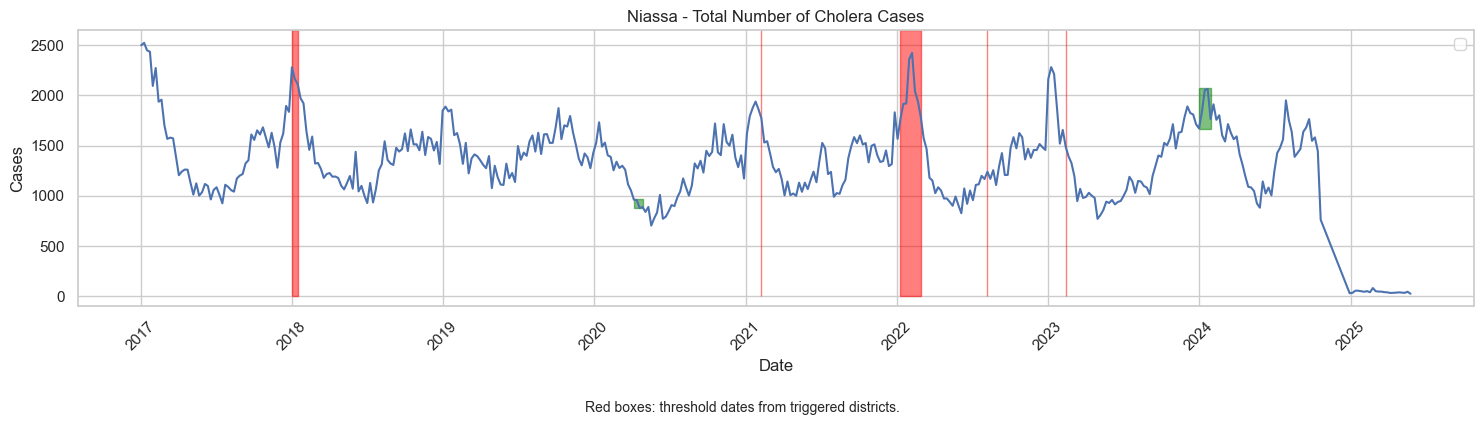

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


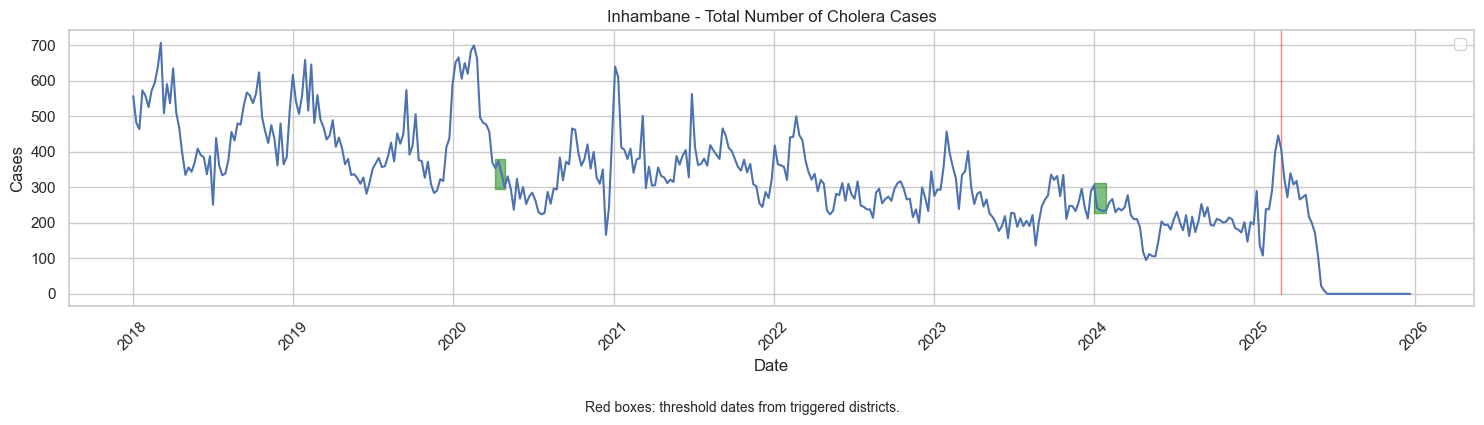

C:\Users\pauni\AppData\Local\Temp\ipykernel_42148\2305548982.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


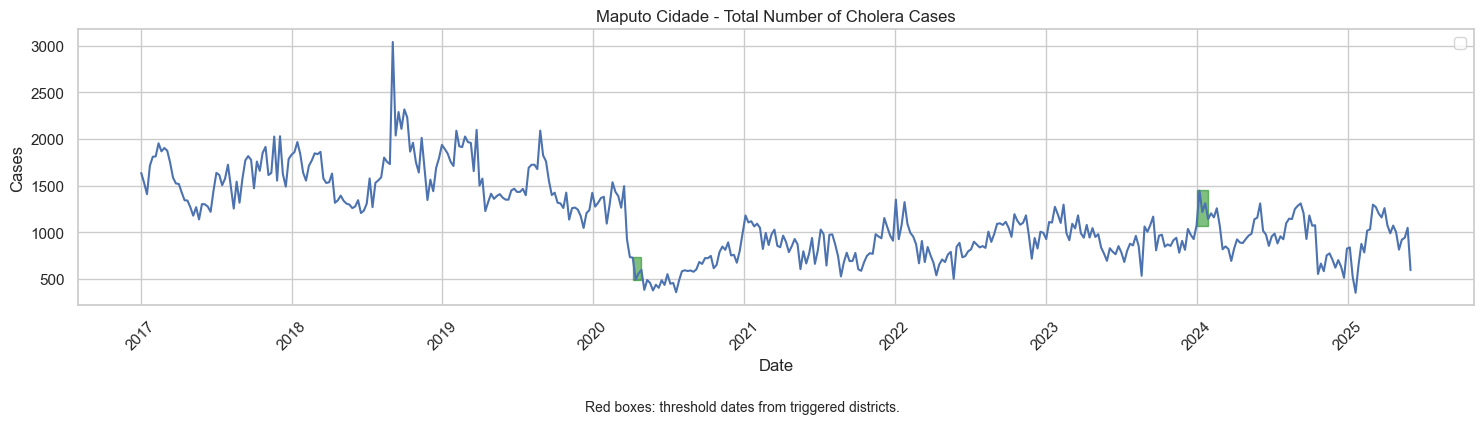

In [87]:
unique_provinces = district_df_with_percentiles["province"].unique()

for province in unique_provinces:
    # All districts in the province (include all, not just triggered ones)
    province_df = district_df_with_percentiles[
        district_df_with_percentiles["province"] == province
    ]

    if province_df.empty:
        continue

    agg = (
        province_df.groupby("date")
        .agg({"cases": "sum", "cases_per_100k": "sum"})
        .reset_index()
    )

    # Get all threshold dates from triggered districts in this province
    subset_trigger = district_df_with_percentiles[
        (district_df_with_percentiles["province"] == province)
        & (
            district_df_with_percentiles["district"].isin(
                district_trigger_99th["district"].unique()
            )
        )
    ]

    threshold_dates = subset_trigger[subset_trigger["three_consec_crossing"]][
        "date"
    ]

    agg["three_consec_crossing"] = agg["date"].isin(threshold_dates)

    # Plot
    plt.figure(figsize=(15, 4))
    sns.lineplot(data=agg, x="date", y="cases")

    # for date in red_line_dates:
    #    plt.axvline(x=date, color="red", linestyle="-", linewidth=1)

    highlight_month_boxes(agg, cerf_y_lim="cases")
    plt.title(f"{province} - Total Number of Cholera Cases")
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.figtext(
        0.5,
        -0.05,
        "Red boxes: threshold dates from triggered districts.",
        wrap=True,
        horizontalalignment="center",
        fontsize=10,
    )
    plt.show()